# `Telecom Churn Case Study`
*The purpose of this assignment is to develop a classification model which should serve two purposes:*
 - It will be used to predict whether a high-value prepaid customer will churn or not.
 - It will be used to identify important variables that are strong predictors of churn.

## Step 1: Importing packages, Reading & Understanding Data

In [242]:
# Importing all required packages
import numpy as np
import pandas as pd
from datetime import datetime as dt
import scipy.stats as stats
from scipy.stats import norm, skew #for some statistics
import re

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib
from mlxtend.plotting import plot_confusion_matrix

# To Scale our data
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# For building model
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.datasets import fetch_mldata
from sklearn import metrics
from RegscorePy import *
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

In [46]:
#reading the telecom dataset
telecom = pd.read_csv("telecom_churn_data.csv",  sep = ',',encoding = "ISO-8859-1")
telecom.head()

mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0     7000842753        109           0.000           0.000           0.000   
1     7001865778        109           0.000           0.000           0.000   
2     7001625959        109           0.000           0.000           0.000   
3     7001204172        109           0.000           0.000           0.000   
4     7000142493        109           0.000           0.000           0.000   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0            6/30/2014            7/31/2014            8/31/2014   
1            6/30/2014            7/31/2014            8/31/2014   
2            6/30/2014            7/31/2014            8/31/2014   
3            6/30/2014            7/31/2014            8/31/2014   
4            6/30/2014            7/31/2014            8/31/2014   

  last_date_of_month_9  arpu_6     ...      sachet_3g_9  fb_user_6  fb_user_7  \
0            9/30/2014 197.385     ...                0      1.000      1.000   
1            9/30/2014  34.047     ...                0        nan      1.000   
2            9/30/2014 167.690     ...                0        nan        nan   
3            9/30/2014 221.338     ...                0        nan        nan   
4            9/30/2014 261.636     ...                0      0.000        nan   

   fb_user_8  fb_user_9   aon  aug_vbc_3g  jul_vbc_3g  jun_vbc_3g  sep_vbc_3g  
0      1.000        nan   968      30.400       0.000     101.200       3.580  
1      1.000        nan  1006       0.000       0.000       0.000       0.000  
2        nan      1.000  1103       0.000       0.000       4.170       0.000  
3        nan        nan  2491       0.000       0.000       0.000       0.000  
4        nan        nan  1526       0.000       0.000       0.000       0.000  

[5 rows x 226 columns]

In [4]:
# Checking the datatypes
telecom.dtypes

mobile_number             int64
circle_id                 int64
loc_og_t2o_mou          float64
std_og_t2o_mou          float64
loc_ic_t2o_mou          float64
last_date_of_month_6     object
last_date_of_month_7     object
last_date_of_month_8     object
last_date_of_month_9     object
arpu_6                  float64
arpu_7                  float64
arpu_8                  float64
arpu_9                  float64
onnet_mou_6             float64
onnet_mou_7             float64
onnet_mou_8             float64
onnet_mou_9             float64
offnet_mou_6            float64
offnet_mou_7            float64
offnet_mou_8            float64
offnet_mou_9            float64
roam_ic_mou_6           float64
roam_ic_mou_7           float64
roam_ic_mou_8           float64
roam_ic_mou_9           float64
roam_og_mou_6           float64
roam_og_mou_7           float64
roam_og_mou_8           float64
roam_og_mou_9           float64
loc_og_t2t_mou_6        float64
                         ...   
arpu_2g_

In [5]:
# Checking the shape of the dataframe
print(telecom.shape)

(99999, 226)


## Step 2: Data Preparation

### Handling Duplicate Rows

In [6]:
# removing duplicate rows
telecom.drop_duplicates(subset='mobile_number')
telecom.shape

(99999, 226)

*No duplicate rows*

### Dropping Unnecessary Columns NOT needed for Analysis

In [7]:
# Identifying if any column exists with only null values
telecom.isnull().all(axis=0).any()

False

In [8]:
# Dropping all columns with only 0 values
telecom.loc[:, (telecom != 0).any(axis=0)]
telecom.shape

(99999, 226)

In [47]:
#Remove columns which has only one unique value

telecom= telecom.loc[:,telecom.nunique()!=1]
telecom.shape

(99999, 210)

### Handling of Date Columns
*Each of the date columns have the month and year part same. Only the day part varies. Hence extracting the day from the date for all the date columns*

In [48]:
# Finding the date columns in the dataframe(type = categorical)
date_columns = telecom.dtypes[telecom.dtypes == "object"].index
date_columns

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9'],
      dtype='object')

In [49]:
# Extracting the 'day' from date
telecom['date_of_last_rech_6'] =  pd.to_datetime(telecom['date_of_last_rech_6'], format='%m/%d/%Y').dt.day
telecom['date_of_last_rech_7'] =  pd.to_datetime(telecom['date_of_last_rech_7'], format='%m/%d/%Y').dt.day
telecom['date_of_last_rech_8'] =  pd.to_datetime(telecom['date_of_last_rech_8'], format='%m/%d/%Y').dt.day
telecom['date_of_last_rech_9'] =  pd.to_datetime(telecom['date_of_last_rech_9'], format='%m/%d/%Y').dt.day

telecom['date_of_last_rech_data_6'] =  pd.to_datetime(telecom['date_of_last_rech_data_6'], format='%m/%d/%Y').dt.day
telecom['date_of_last_rech_data_7'] =  pd.to_datetime(telecom['date_of_last_rech_data_7'], format='%m/%d/%Y').dt.day
telecom['date_of_last_rech_data_8'] =  pd.to_datetime(telecom['date_of_last_rech_data_8'], format='%m/%d/%Y').dt.day
telecom['date_of_last_rech_data_9'] =  pd.to_datetime(telecom['date_of_last_rech_data_9'], format='%m/%d/%Y').dt.day

telecom[date_columns].dtypes

date_of_last_rech_6         float64
date_of_last_rech_7         float64
date_of_last_rech_8         float64
date_of_last_rech_9         float64
date_of_last_rech_data_6    float64
date_of_last_rech_data_7    float64
date_of_last_rech_data_8    float64
date_of_last_rech_data_9    float64
dtype: object

In [50]:
# Inspecting the date columns after transformation
telecom[date_columns].head()

date_of_last_rech_6  date_of_last_rech_7  date_of_last_rech_8  \
0               21.000               16.000                8.000   
1               29.000               31.000               28.000   
2               17.000               24.000               14.000   
3               28.000               31.000               31.000   
4               26.000               28.000                9.000   

   date_of_last_rech_9  date_of_last_rech_data_6  date_of_last_rech_data_7  \
0               28.000                    21.000                    16.000   
1               30.000                       nan                    25.000   
2               29.000                       nan                       nan   
3               30.000                       nan                       nan   
4               28.000                     4.000                       nan   

   date_of_last_rech_data_8  date_of_last_rech_data_9  
0                     8.000                       nan  
1                    10.000                       nan  
2                       nan                    17.000  
3                       nan                       nan  
4                       nan                       nan

In [51]:
# Ensuring there are no categorical columns left in the dataframe
cols = telecom.columns
num_cols = telecom._get_numeric_data().columns
list(set(cols) - set(num_cols))

[]

### Handling Null Values

In [52]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(telecom.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(telecom.isnull().sum()/telecom.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1)

Total  Percentage
night_pck_user_6          74846      74.850
arpu_2g_6                 74846      74.850
count_rech_3g_6           74846      74.850
av_rech_amt_data_6        74846      74.850
count_rech_2g_6           74846      74.850
max_rech_data_6           74846      74.850
fb_user_6                 74846      74.850
date_of_last_rech_data_6  74846      74.850
total_rech_data_6         74846      74.850
arpu_3g_6                 74846      74.850
night_pck_user_7          74428      74.430
arpu_2g_7                 74428      74.430
total_rech_data_7         74428      74.430
arpu_3g_7                 74428      74.430
max_rech_data_7           74428      74.430
av_rech_amt_data_7        74428      74.430
count_rech_3g_7           74428      74.430
date_of_last_rech_data_7  74428      74.430
count_rech_2g_7           74428      74.430
fb_user_7                 74428      74.430
date_of_last_rech_data_9  74077      74.080
arpu_2g_9                 74077      74.080
max_rech_data_9           74077      74.080
count_rech_3g_9           74077      74.080
fb_user_9                 74077      74.080
av_rech_amt_data_9        74077      74.080
total_rech_data_9         74077      74.080
arpu_3g_9                 74077      74.080
count_rech_2g_9           74077      74.080
night_pck_user_9          74077      74.080
...                         ...         ...
aug_vbc_3g                    0       0.000
jul_vbc_3g                    0       0.000
vol_2g_mb_9                   0       0.000
vol_2g_mb_7                   0       0.000
total_og_mou_7                0       0.000
vol_2g_mb_6                   0       0.000
total_og_mou_8                0       0.000
total_og_mou_9                0       0.000
jun_vbc_3g                    0       0.000
total_ic_mou_6                0       0.000
total_ic_mou_7                0       0.000
total_ic_mou_8                0       0.000
total_ic_mou_9                0       0.000
total_rech_num_6              0       0.000
total_rech_num_7              0       0.000
total_rech_num_8              0       0.000
total_rech_num_9              0       0.000
total_rech_amt_6              0       0.000
total_rech_amt_7              0       0.000
total_rech_amt_8              0       0.000
total_rech_amt_9              0       0.000
max_rech_amt_6                0       0.000
max_rech_amt_7                0       0.000
max_rech_amt_8                0       0.000
max_rech_amt_9                0       0.000
last_day_rch_amt_6            0       0.000
last_day_rch_amt_7            0       0.000
last_day_rch_amt_8            0       0.000
last_day_rch_amt_9            0       0.000
mobile_number                 0       0.000

[210 rows x 2 columns]

### *Visualizing occurence of Null values in the columns based on rows*

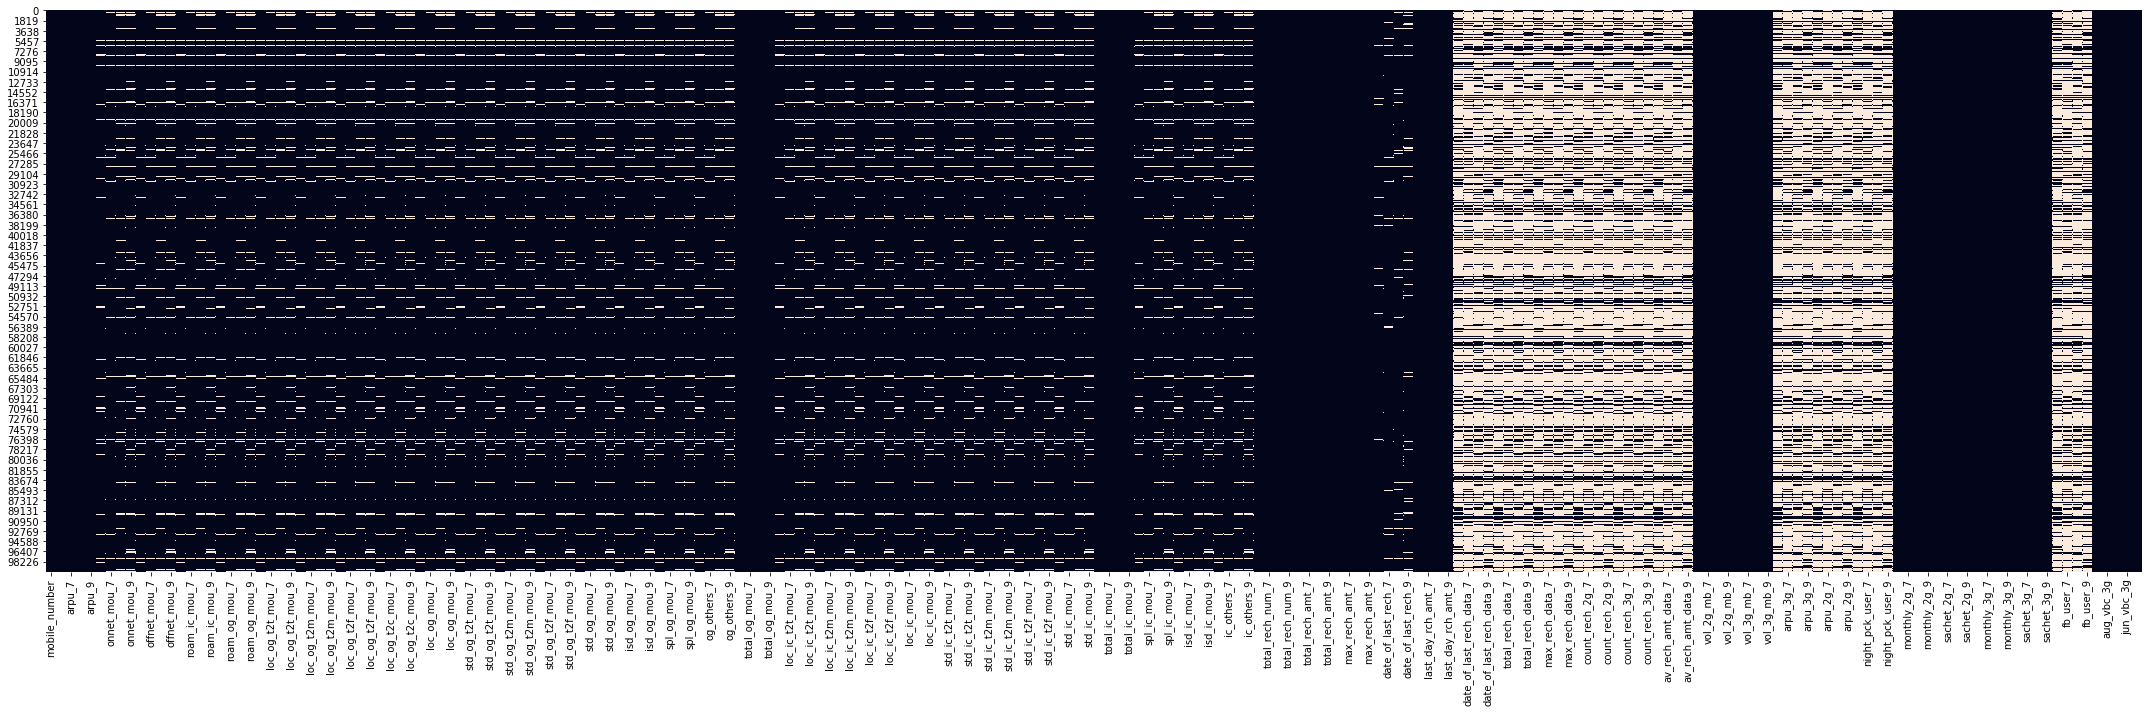

In [34]:
plt.figure(figsize=(30,10))
sns.heatmap(telecom.isnull(), cbar=False)

plt.tight_layout()
plt.show()

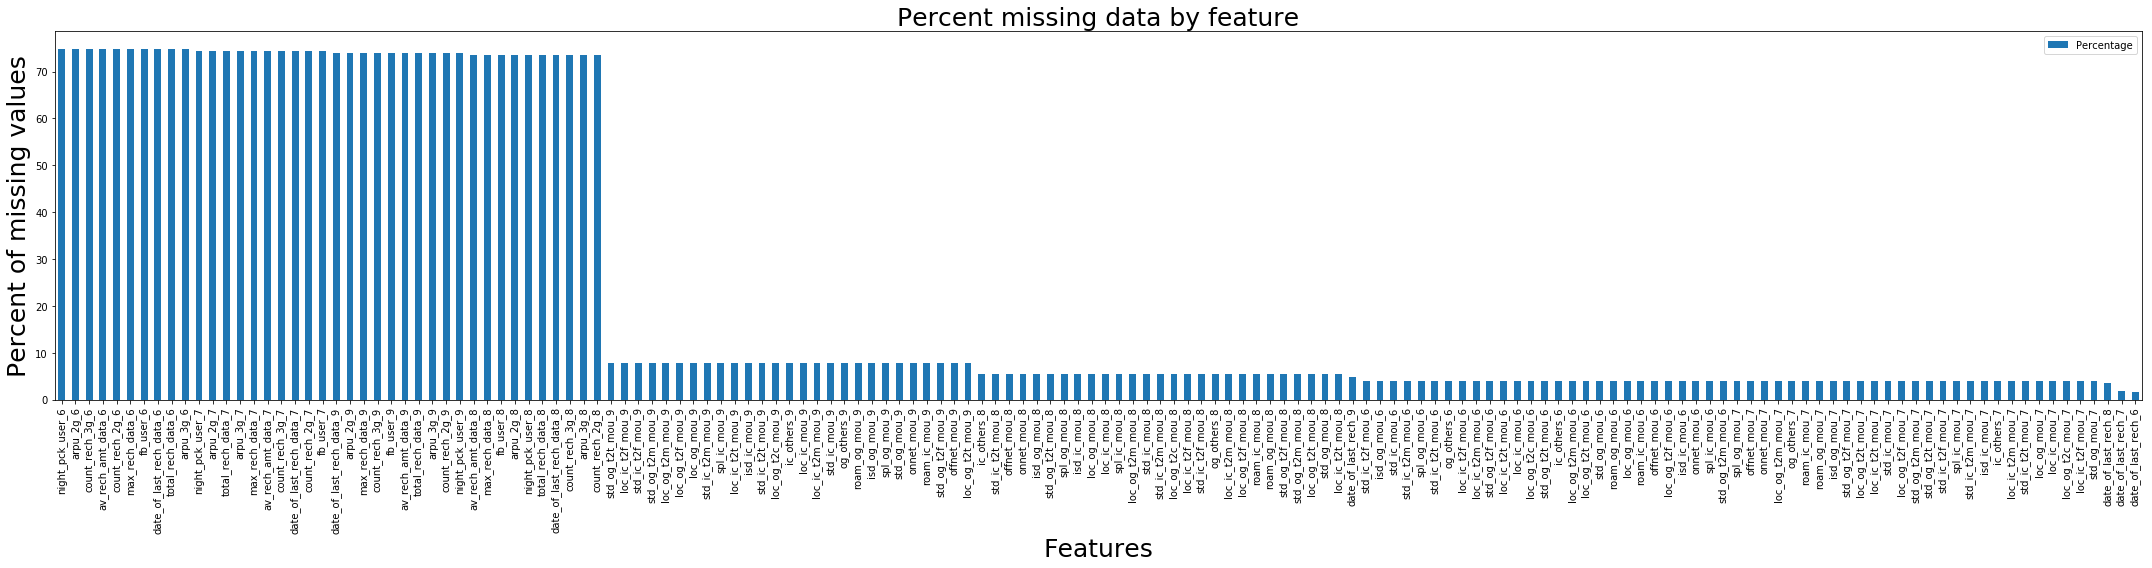

In [35]:
# Percentage of null values in the variables
percentage = percentage.loc[percentage['Percentage'] > 0]
percentage.plot.bar(figsize=(30,8))
plt.xlabel('Features', fontsize=25)
plt.ylabel('Percent of missing values', fontsize=25)
plt.title('Percent missing data by feature', fontsize=25)
plt.tight_layout()
plt.show()

#### Replace all NAN values with 0 as per design judgement

In [53]:
# Selecting columns with null values
columns_null = total.loc[total['Total'] >= 0].index
columns_null

Index(['night_pck_user_6', 'arpu_2g_6', 'count_rech_3g_6',
       'av_rech_amt_data_6', 'count_rech_2g_6', 'max_rech_data_6', 'fb_user_6',
       'date_of_last_rech_data_6', 'total_rech_data_6', 'arpu_3g_6',
       ...
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'last_day_rch_amt_6',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'last_day_rch_amt_9',
       'mobile_number'],
      dtype='object', length=210)

In [54]:
# Filling all null values with 0
telecom[columns_null] = telecom[columns_null].fillna(0)

In [55]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(telecom.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(telecom.isnull().sum()/telecom.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1).head()

Total  Percentage
sep_vbc_3g            0       0.000
std_og_t2f_mou_9      0       0.000
loc_ic_t2t_mou_9      0       0.000
loc_ic_t2t_mou_8      0       0.000
loc_ic_t2t_mou_7      0       0.000

### *Identification of High Value Customers*

*High-Value customers are those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months - June and July (the good phase).*

In [56]:
# Total call and data recharge for a month = total call recharge amount + Avg data recharge amount*total no of data recharges
telecom['total_data_and_call_rech_6'] = telecom["total_rech_amt_6"] + telecom['av_rech_amt_data_6']*telecom['total_rech_data_6']
telecom['total_data_and_call_rech_7'] = telecom['total_rech_amt_7'] + telecom['av_rech_amt_data_7']*telecom['total_rech_data_7']
telecom['total_data_and_call_rech_8'] = telecom['total_rech_amt_8'] + telecom['av_rech_amt_data_8']*telecom['total_rech_data_8']

# Average recharge amount for June and July = (Total call and data recharge for June + Total call and data recharge for July)/2
telecom['avg_rech_6_&_7'] = (telecom['total_data_and_call_rech_6'] + telecom['total_data_and_call_rech_7'])/2
telecom[['total_rech_amt_6','av_rech_amt_data_6','total_rech_data_6','total_data_and_call_rech_6','total_rech_amt_7','av_rech_amt_data_7','total_rech_data_7','total_data_and_call_rech_7','avg_rech_6_&_7','total_data_and_call_rech_8']].head()

total_rech_amt_6  av_rech_amt_data_6  total_rech_data_6  \
0               362             252.000              1.000   
1                74               0.000              0.000   
2               168               0.000              0.000   
3               230               0.000              0.000   
4               196              56.000              1.000   

   total_data_and_call_rech_6  total_rech_amt_7  av_rech_amt_data_7  \
0                     614.000               252             252.000   
1                      74.000               384             154.000   
2                     168.000               315               0.000   
3                     230.000               310               0.000   
4                     252.000               350               0.000   

   total_rech_data_7  total_data_and_call_rech_7  avg_rech_6_&_7  \
0              1.000                     504.000         559.000   
1              1.000                     538.000         306.000   
2              0.000                     315.000         241.500   
3              0.000                     310.000         270.000   
4              0.000                     350.000         301.000   

   total_data_and_call_rech_8  
0                     504.000  
1                     383.000  
2                     116.000  
3                     601.000  
4                     287.000

In [57]:
# Calculating X
# X is the 70th percentile of the average recharge amount in the first two months - June and July
X = telecom['avg_rech_6_&_7'].quantile(0.7)
X

478.0

In [58]:
# Filtering high value customers
telecom = telecom.loc[telecom['avg_rech_6_&_7'] >= telecom['avg_rech_6_&_7'].quantile(0.7)]
telecom.shape

(30001, 214)

In [59]:
# Dropping all the extra columns
columns_drop = ['total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8'
                 ,'total_rech_data_6','total_rech_data_7','total_rech_data_8']
columns_drop

['total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'av_rech_amt_data_6',
 'av_rech_amt_data_7',
 'av_rech_amt_data_8',
 'total_rech_data_6',
 'total_rech_data_7',
 'total_rech_data_8']

In [60]:
telecom = telecom.drop(columns_drop, axis=1)
telecom.shape

(30001, 205)

### Average Recharge amount for the first 3 months

In [61]:
#telecom['avg_rech_6_7_&_8'] = (telecom['total_data_and_call_rech_6'] + telecom['total_data_and_call_rech_7'] + telecom['total_data_and_call_rech_8'])/3
#telecom.head()

### *Tagging of Churners*

*Churners are those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase(4th month).*

In [62]:
# Selecting columns for churn calculation
churn_columns = ['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']
churn_columns

['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9', 'vol_3g_mb_9']

In [63]:
# Calculating total call and data charges for September
telecom['total_calls_&_data_9'] = telecom['total_ic_mou_9'] + telecom['total_og_mou_9'] + telecom['vol_2g_mb_9'] + telecom['vol_3g_mb_9']
telecom[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9','total_calls_&_data_9']].head()  

total_ic_mou_9  total_og_mou_9  vol_2g_mb_9  vol_3g_mb_9  \
0            0.000           0.000        0.000        0.000   
7            0.000           0.000        0.000        0.000   
8           34.910         142.180        0.000        0.000   
21         252.610        1031.530        0.000        0.000   
23         127.480         127.630       13.930      314.740   

    total_calls_&_data_9  
0                  0.000  
7                  0.000  
8                177.090  
21              1284.140  
23               583.780

In [64]:
# Calculating Churn. If total amount = 0, then churn, else non churn
telecom['churn'] = telecom['total_calls_&_data_9'].apply(lambda x:1 if x==0 else 0)
telecom[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9','total_calls_&_data_9','churn']].head()

total_ic_mou_9  total_og_mou_9  vol_2g_mb_9  vol_3g_mb_9  \
0            0.000           0.000        0.000        0.000   
7            0.000           0.000        0.000        0.000   
8           34.910         142.180        0.000        0.000   
21         252.610        1031.530        0.000        0.000   
23         127.480         127.630       13.930      314.740   

    total_calls_&_data_9  churn  
0                  0.000      1  
7                  0.000      1  
8                177.090      0  
21              1284.140      0  
23               583.780      0

### *Remove all attributes of the Churn Phase(4th Month)*

In [65]:
# removing all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).
cols = [c for c in telecom.columns if c[-2:] != '_9']
telecom=telecom[cols]
telecom = telecom.drop('sep_vbc_3g', axis=1)
telecom.shape

(30001, 154)

In [66]:
# Re inspecting total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(telecom.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(telecom.isnull().sum()/telecom.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1).head()

Total  Percentage
churn                 0       0.000
spl_og_mou_8          0       0.000
loc_ic_t2t_mou_6      0       0.000
total_og_mou_8        0       0.000
total_og_mou_7        0       0.000

In [30]:
telecom.to_csv("telecom1.csv", sep=',')

## Step 3: Data Visualisation

### Total Recharge distribution in different months for Churn and Churn Customers

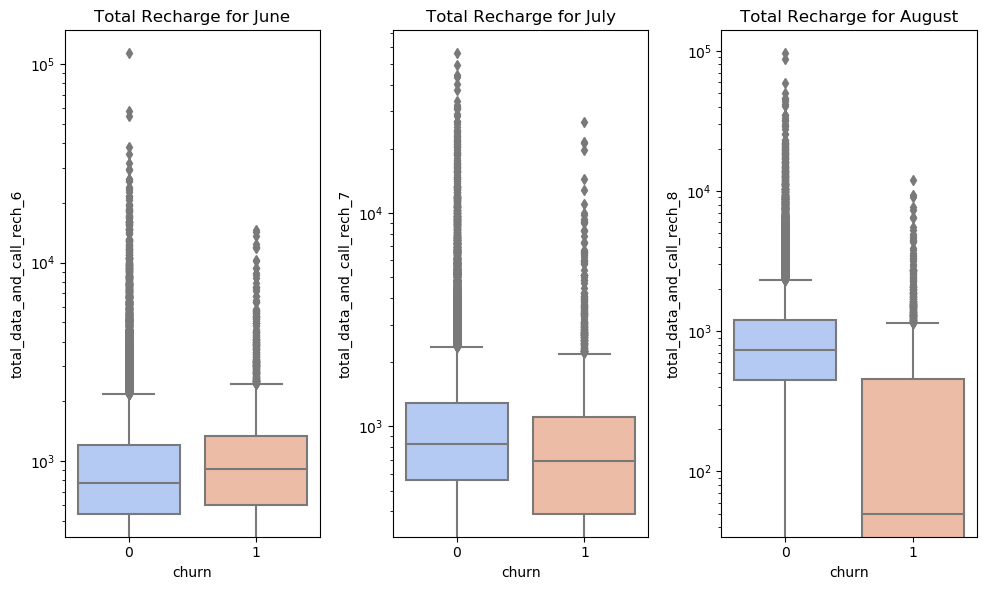

In [67]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10, 6), dpi=100, facecolor='w', edgecolor='k', frameon='True')

# subplot 1
plt.subplot(1, 3, 1)
sns.boxplot(x='churn', y='total_data_and_call_rech_6', palette='coolwarm', data=telecom)
# setting y scale as log y
plt.yscale('log')
# plot title
plt.title("Total Recharge for June")

# subplot 2
plt.subplot(1, 3, 2)
sns.boxplot(x='churn', y='total_data_and_call_rech_7', palette='coolwarm', data=telecom)
# setting y scale as log y
plt.yscale('log')
# plot title
plt.title("Total Recharge for July")

# subplot 3
plt.subplot(1, 3, 3)
sns.boxplot(x='churn', y='total_data_and_call_rech_8', palette='coolwarm', data=telecom)
# setting y scale as log y
plt.yscale('log')
# plot title
plt.title("Total Recharge for August")

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

#### From the above plot, we can observe that with the passing of months after the customer has taken the network connection, the total recharge made by majority of Non-Churn customers follows an increasing trend.

 - During the first month of the good phase (June), the total recharge made by majority of both Churn and Non-Churn customers are almost same.
 - During the second month of the good phase (July), the total recharge made by majority of Non-Churn customers is slightly more than those made by Churn customers.
 - However, during the action phase (August), the total recharge made by majority of Non-Churn customers is significantly more than those made by Churn customers.

### Date of Last Call Recharge in August for Churn and Non-Churn customers

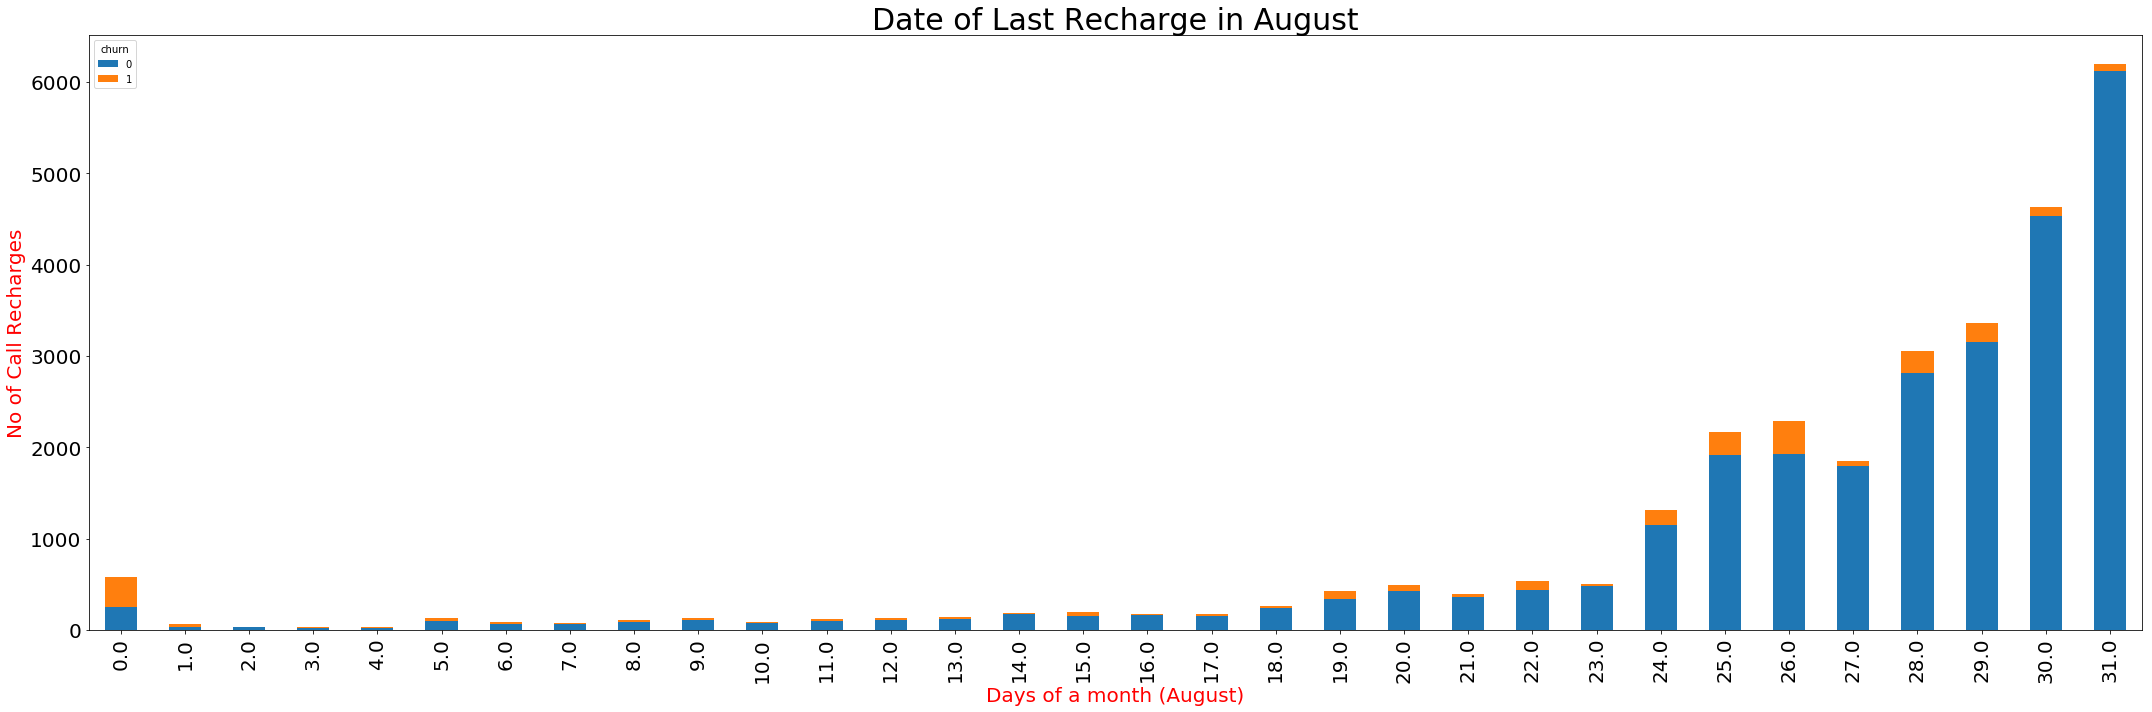

In [68]:
telecom.groupby(["date_of_last_rech_8", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10), fontsize = 20) 
# plot title
plt.title("Date of Last Recharge in August", fontsize = 30)
# plot x axis label
plt.xlabel('Days of a month (August)', fontsize = 20, color='r')
# plot y axis label
plt.ylabel('No of Call Recharges', fontsize = 20, color='r')

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

*From the above plot, we can observe that the last call recharge for a particular month for both churn and non churn customers is done much lesser in the initial days of the month than towards the end of it and it has a more or less gradual increasing trend.*

We can see this trend for other months also.

### Date of Last Data Recharge in August for Churn and Non-Churn customers

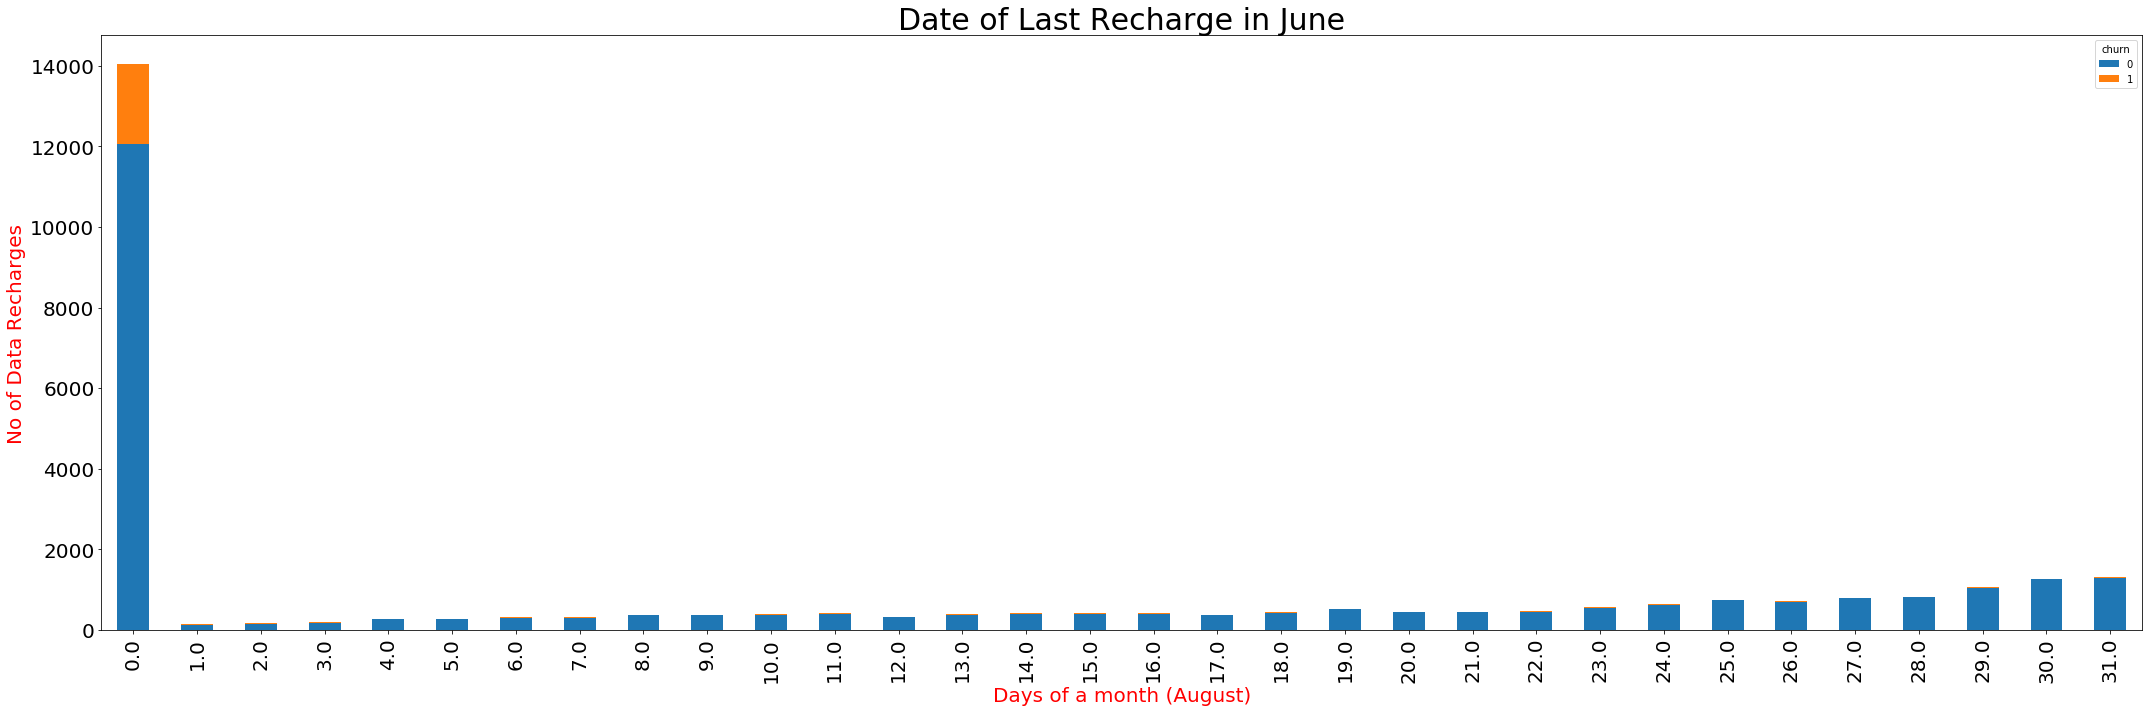

In [69]:
telecom.groupby(["date_of_last_rech_data_8", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10), fontsize = 20) 
# plot title
plt.title("Date of Last Recharge in June", fontsize = 30)
# plot x axis label
plt.xlabel('Days of a month (August)', fontsize = 20, color='r')
# plot y axis label
plt.ylabel('No of Data Recharges', fontsize = 20, color='r')

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

*From the above plot, we can observe that the last data recharge for a particular month for both churn and non churn customers has a miniscile increasing trend. The high reading corrsponding to 0 day symbolises customers who haven't done any data recharge for the month.*

We can see this trend for other months also.

### Age of customers on the network

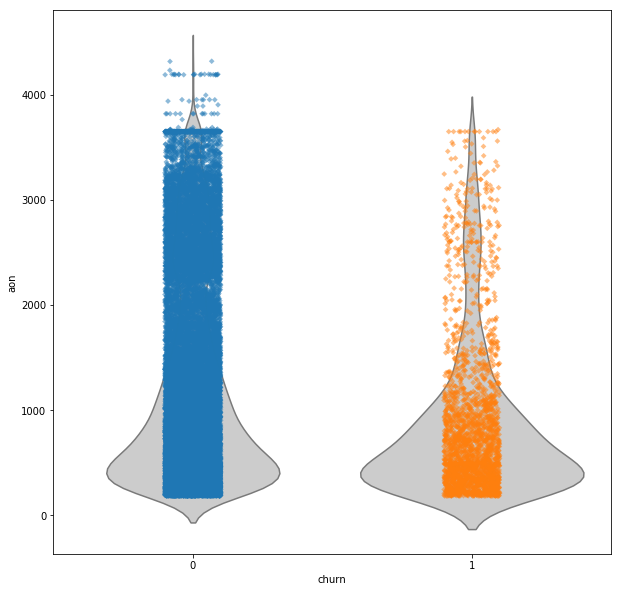

In [70]:
plt.subplots(figsize=(10,10))

g = sns.violinplot(x="churn", y="aon", data=telecom, inner=None,color="0.8")
g = sns.stripplot(x="churn", y="aon", data=telecom, jitter=True, marker="D", size=4, alpha=0.5,edgecolor="gray")

#g.set_yticks(np.arange(0,80,5))
#plt.yscale('log')
g
plt.show()

*As we can see in the chart, the bars are widest below 1000 days. On the other hand, if we look at customers who have quit, they are the highest in the first few months. But they gradually start to quit as the plot becomes narrower with the increase of network age.*

### Correlation of important indicators of churn

In [72]:
cols = [c for c in telecom.columns if c[-2:] == '_8']
telecom_8=telecom[cols]
telecom_8.head()

arpu_8  onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
0   213.803        0.000         0.000          0.000          0.000   
7  3171.480       52.290       325.910         31.640         38.060   
8   137.362       35.080       136.480          0.000          0.000   
21  637.760       85.140       983.390          0.000          0.000   
23  366.966       33.580       205.890          0.000          0.000   

    loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
0              0.000             0.000             0.000             0.000   
7             40.280           162.280            53.230             0.000   
8             12.490            50.540             0.000             7.150   
21            23.340           104.810             1.580             0.000   
23            33.580           148.560             0.000            17.710   

    loc_og_mou_8             ...              vol_3g_mb_8  arpu_3g_8  \
0          0.000             ...                  109.610    212.170   
7        255.790             ...                    0.000      0.000   
8         63.040             ...                   11.940     19.830   
21       129.740             ...                    0.000      0.000   
23       182.140             ...                 1009.920    197.270   

    arpu_2g_8  night_pck_user_8  monthly_2g_8  sachet_2g_8  monthly_3g_8  \
0     212.170             0.000             0            0             1   
7       0.000             0.000             0            0             0   
8       0.000             0.000             0            3             0   
21      0.000             0.000             0            0             0   
23    150.670             0.000             0            0             1   

    sachet_3g_8  fb_user_8  total_data_and_call_rech_8  
0             0      1.000                     504.000  
7             0      0.000                    3638.000  
8             0      1.000                     327.000  
21            0      0.000                     718.000  
23            1      1.000                     979.000  

[5 rows x 49 columns]

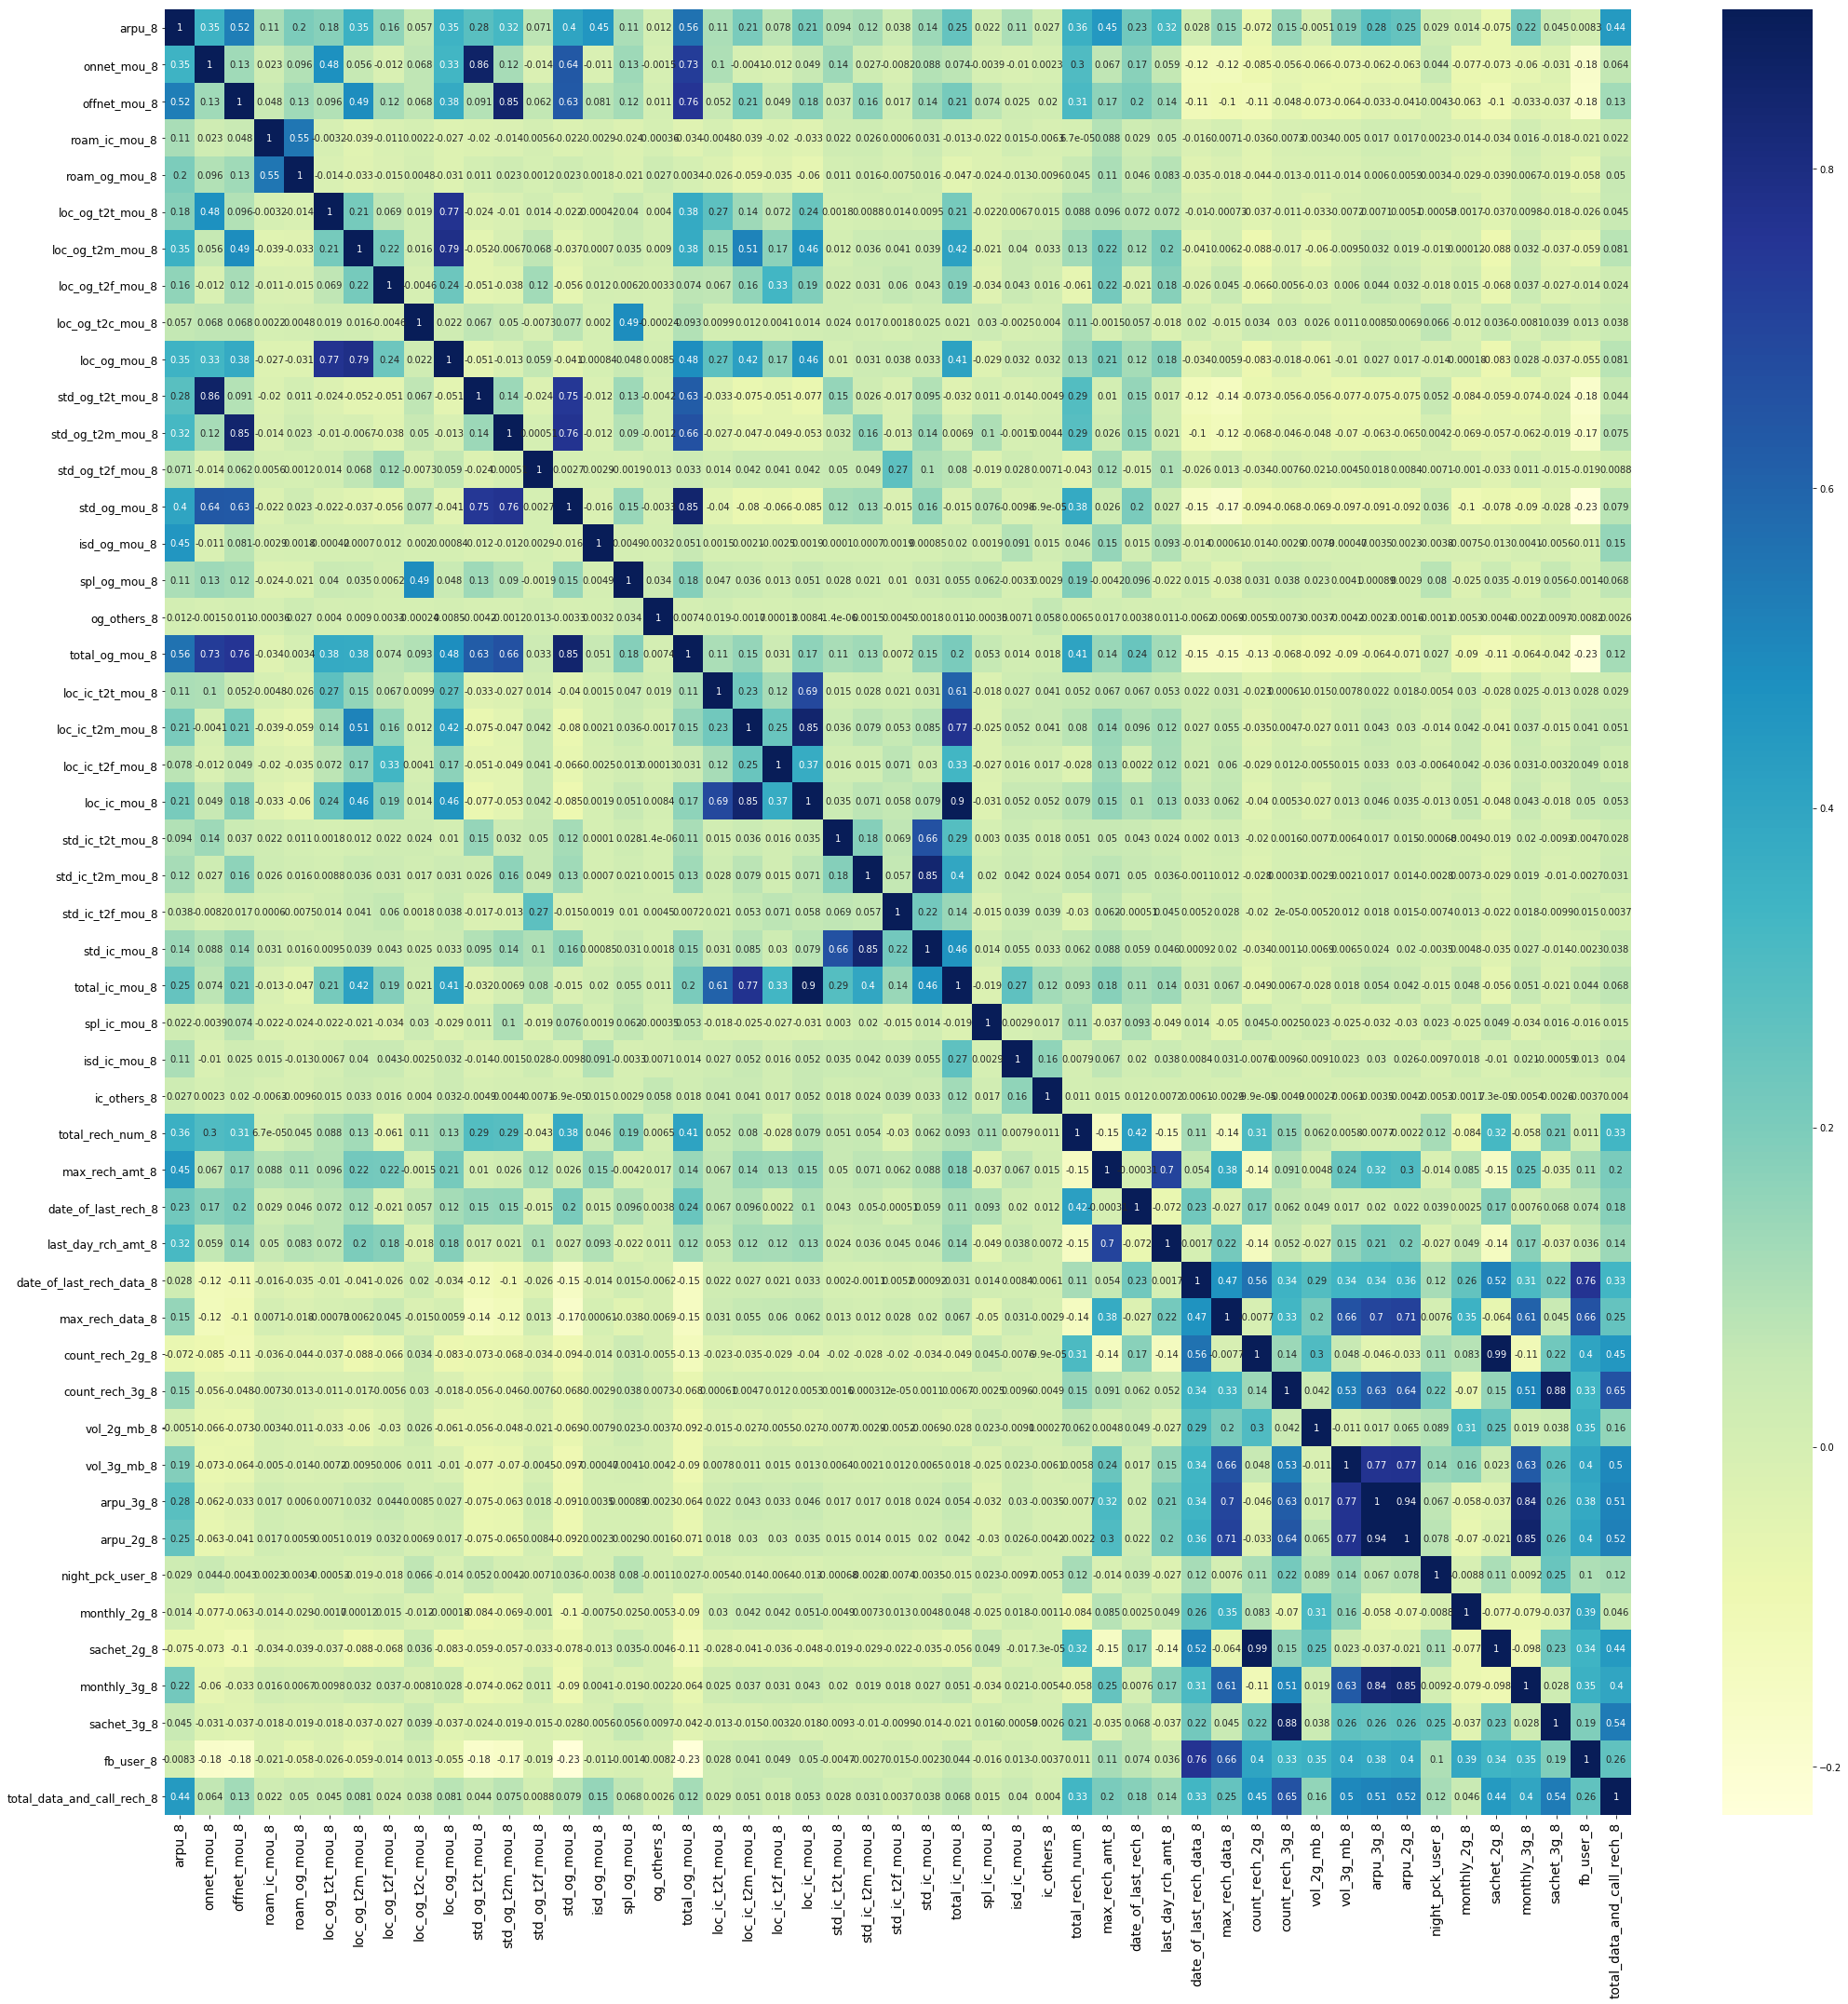

In [73]:
#Correlation map to see how features are correlated with Churn
corrmat = telecom_8.corr()
plt.subplots(figsize=(30,30))
sns.heatmap(corrmat, cmap="YlGnBu", vmax=0.9,annot = True)
plt.xticks(size = 14)
plt.yticks(size = 12)
plt.tight_layout()
plt.show()

*Observations/Inference from the above heatmap*

 - total_ic_mou_8 and loc_ic_mou_8 are highly correlated i.e correlation of .9, so all incoming voice calls are mostly local calls.
 - count_rech_2g_8 and sachet_2g_8 are highly correlated i.e. 0.99, so more 2g sachet buys means more 2g recharge.
 - count_rech_3g_8 and sachet_3g_8 are highly correlated i.e. 0.88, so more 3g sachet buys means more 3g recharge. 
 - arpu_3g_8 and arpu_2g_8 are highly correlated i.e. 0.94.  


*Merging the columns for average revenue from data usage and monthly data usage for both the "good times" phase as well as the "action" phase and dropping the original columns.*

In [74]:
telecom['arpu_2g_3g_6']= telecom['arpu_3g_6']+telecom['arpu_2g_6']
telecom['arpu_2g_3g_7']= telecom['arpu_3g_7']+telecom['arpu_2g_7']
telecom['arpu_2g_3g_8']= telecom['arpu_3g_8']+telecom['arpu_2g_8']

telecom['monthly_2g_3g_6']= telecom['monthly_3g_6']+telecom['monthly_2g_6']
telecom['monthly_2g_3g_7']= telecom['monthly_3g_7']+telecom['monthly_2g_7']
telecom['monthly_2g_3g_8']= telecom['monthly_3g_8']+telecom['monthly_2g_8']

telecom.drop(['total_ic_mou_6','total_ic_mou_7','total_ic_mou_8','monthly_3g_8','monthly_2g_8',
            'monthly_3g_6','monthly_2g_6','monthly_3g_7','monthly_2g_7',
            'arpu_3g_6','arpu_3g_7','arpu_3g_8','arpu_2g_6','arpu_2g_7','arpu_2g_8',
            'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8',
            'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8',
           ],axis=1, inplace = True)

telecom.shape

(30001, 139)

In [118]:
# Reinspecting the heatmap
cols = [c for c in telecom.columns if c[-2:] == '_8']
telecom_8=telecom[cols]
telecom_8.head()

arpu_8  onnet_mou_8  offnet_mou_8  roam_ic_mou_8  roam_og_mou_8  \
0   213.80         0.00          0.00           0.00           0.00   
7  3171.48        52.29        325.91          31.64          38.06   
8   137.36        35.08        136.48           0.00           0.00   
21  637.76        85.14        983.39           0.00           0.00   
23  366.97        33.58        205.89           0.00           0.00   

    loc_og_t2t_mou_8  loc_og_t2m_mou_8  loc_og_t2f_mou_8  loc_og_t2c_mou_8  \
0               0.00              0.00              0.00              0.00   
7              40.28            162.28             53.23              0.00   
8              12.49             50.54              0.00              7.15   
21             23.34            104.81              1.58              0.00   
23             33.58            148.56              0.00             17.71   

    loc_og_mou_8       ...         max_rech_data_8  vol_2g_mb_8  vol_3g_mb_8  \
0           0.00       ...                  252.00         5.75       109.61   
7         255.79       ...                    0.00         0.00         0.00   
8          63.04       ...                   23.00         0.03        11.94   
21        129.74       ...                    0.00         0.00         0.00   
23        182.14       ...                  179.00         0.01      1009.92   

    night_pck_user_8  sachet_2g_8  sachet_3g_8  fb_user_8  \
0               0.00            0            0       1.00   
7               0.00            0            0       0.00   
8               0.00            3            0       1.00   
21              0.00            0            0       0.00   
23              0.00            0            1       1.00   

    total_data_and_call_rech_8  arpu_2g_3g_8  monthly_2g_3g_8  
0                       504.00        424.34                1  
7                      3638.00          0.00                0  
8                       327.00         19.83                0  
21                      718.00          0.00                0  
23                      979.00        347.94                1  

[5 rows x 44 columns]

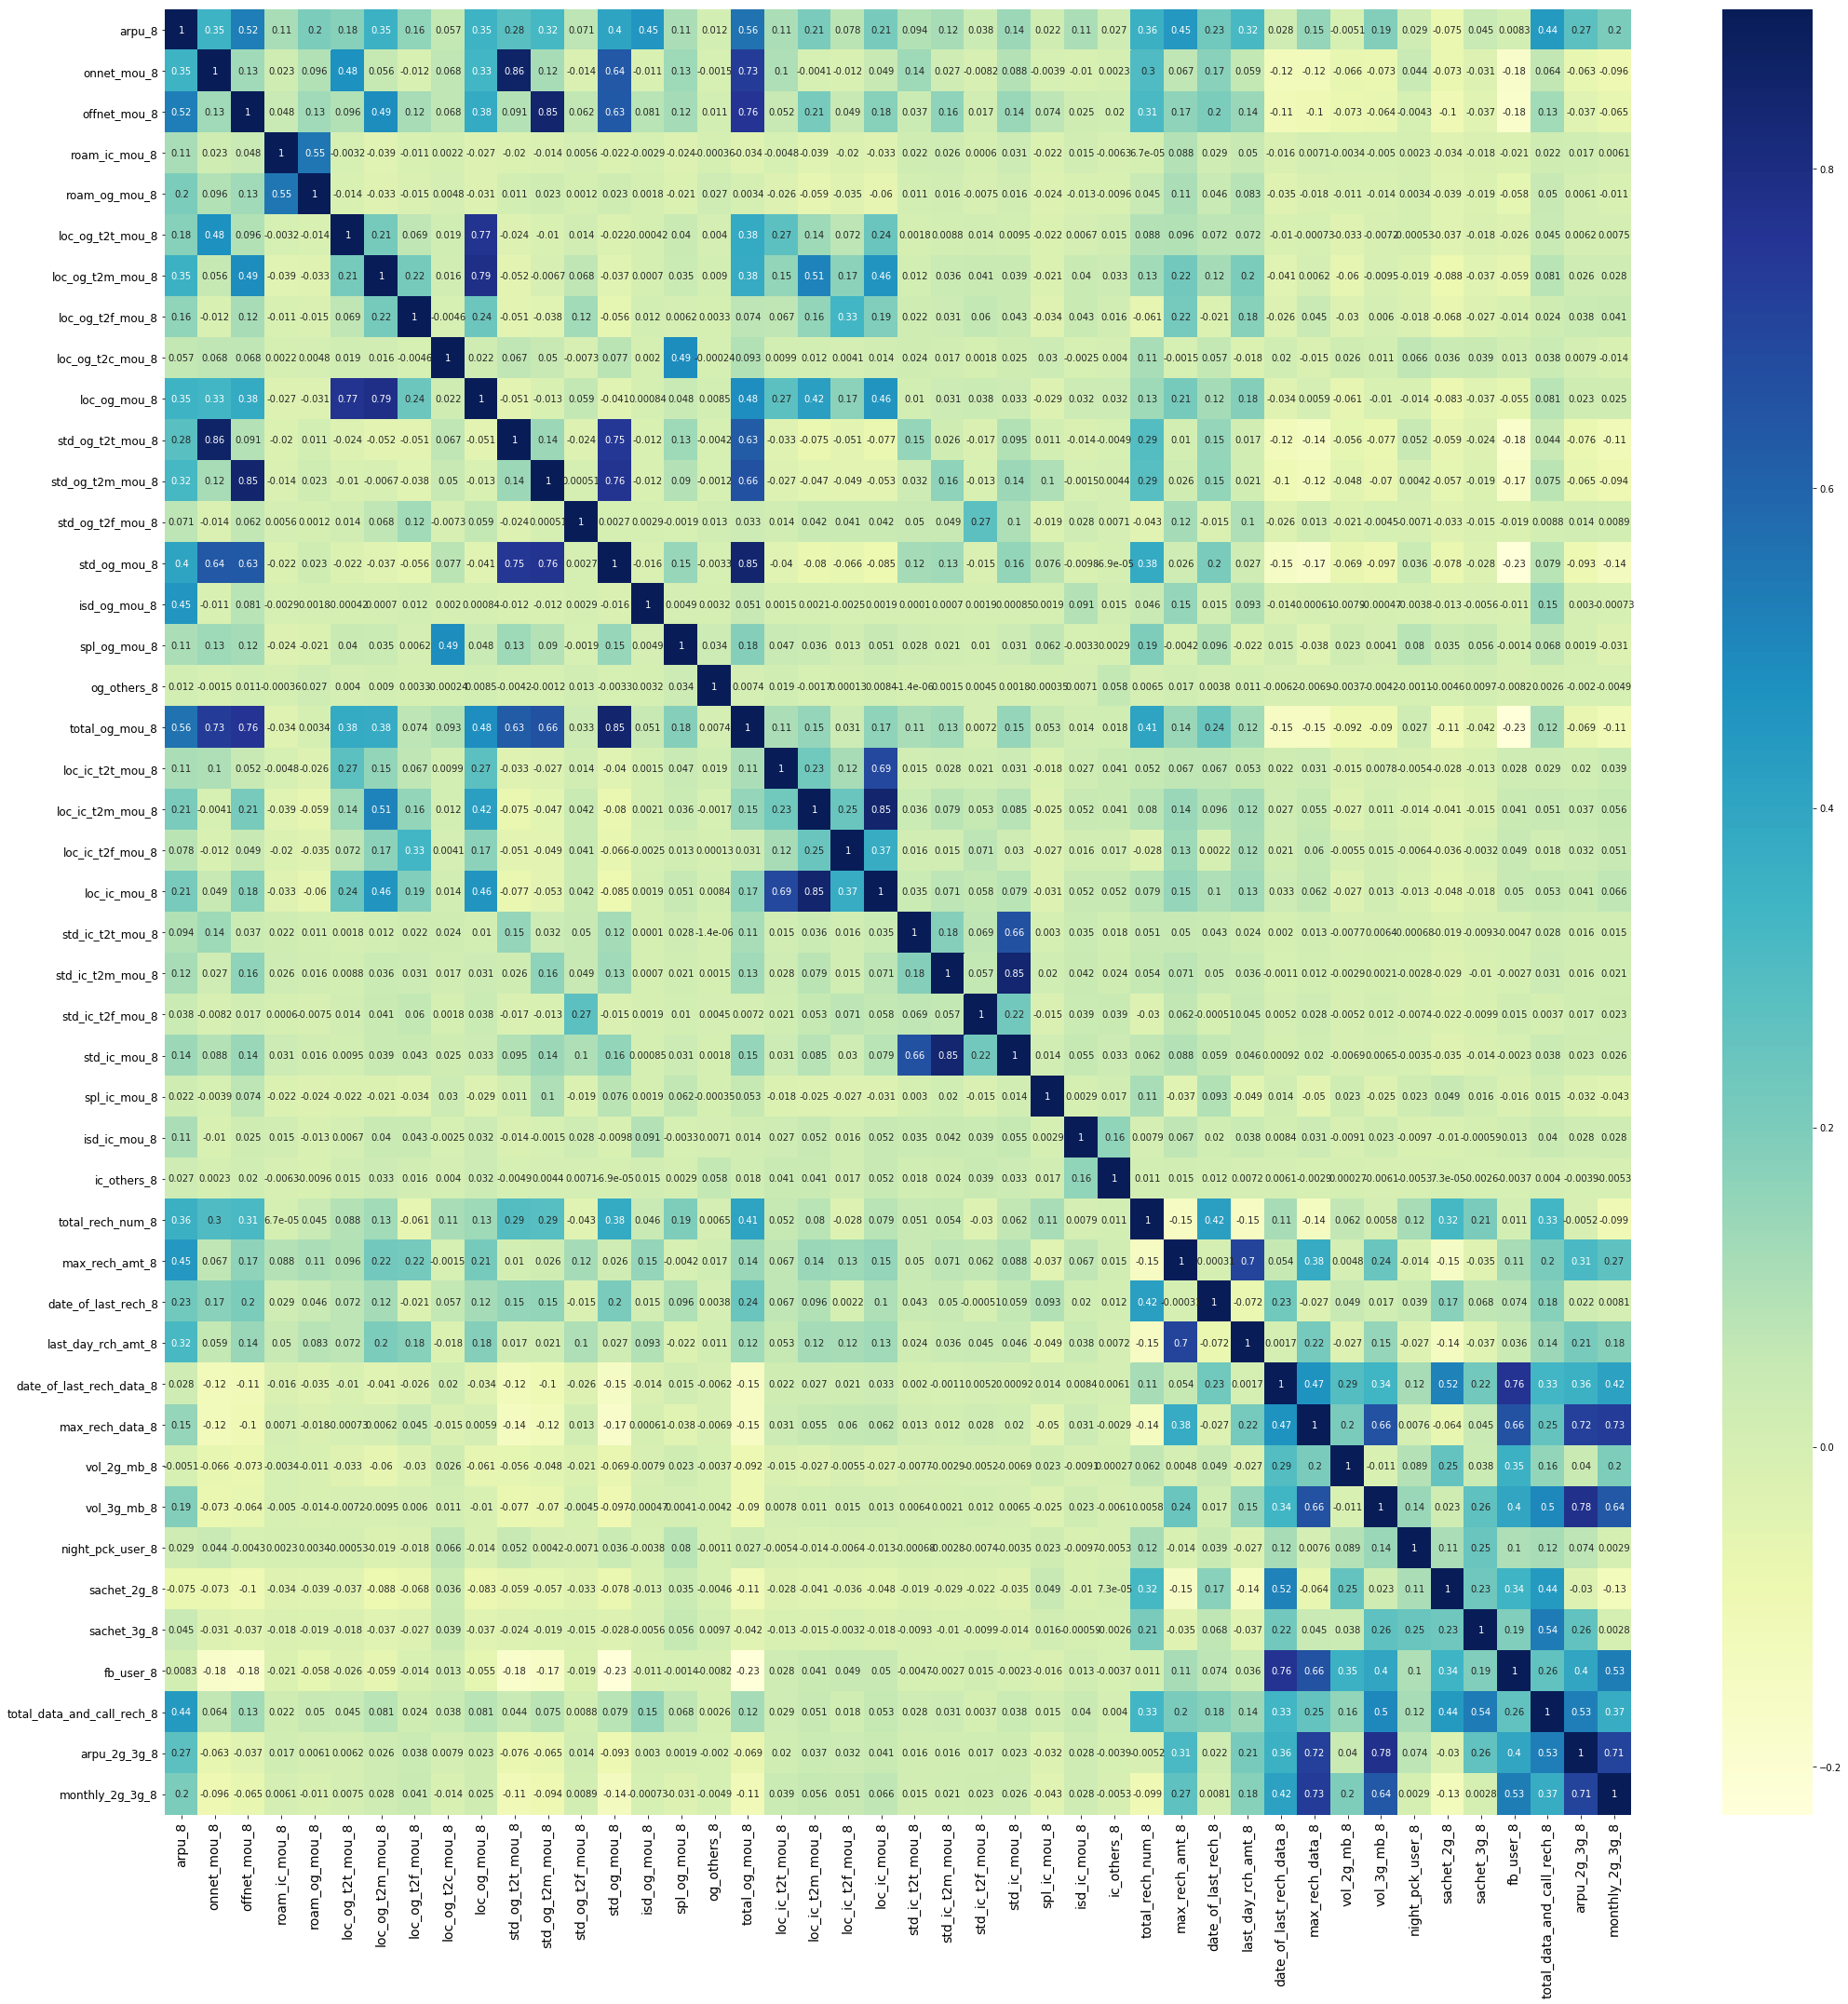

In [76]:
#Correlation map to see how features are correlated with Churn
corrmat = telecom_8.corr()
plt.subplots(figsize=(30,30))
sns.heatmap(corrmat, cmap="YlGnBu", vmax=0.9,annot = True)
plt.xticks(size = 14)
plt.yticks(size = 12)
plt.tight_layout()
plt.show()

*There are some other highly correlated features but we shall leave it for PCA to handle them.*

## Step 4: Churn Rate

In [77]:
### Checking the Lead Conversion Rate
churned = (sum(telecom['churn'])/len(telecom['churn'].index))*100
churned

8.136395453484884

### Visually representing the Churn Rate

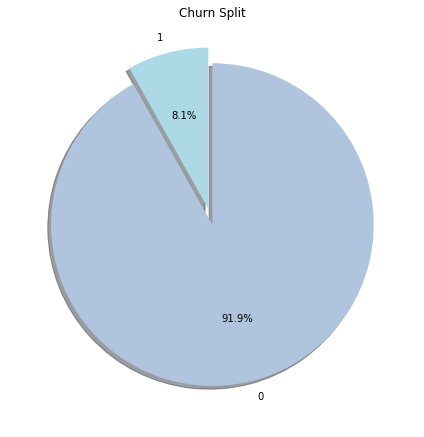

In [78]:
from collections import Counter

labels, values = zip(*Counter(telecom["churn"]).items())
colors = ['lightblue', 'lightsteelblue']
piechart_df = (pd.DataFrame(list(values),list(labels)))
piechart_df = piechart_df.reset_index()

fig = plt.figure(figsize=[6, 6])

plt.pie(piechart_df[0],labels=piechart_df["index"],startangle=90,explode=(0.1,0),autopct="%1.1f%%", shadow=True, colors=colors)
plt.tight_layout()
plt.title("Churn Split")
plt.show()

#### We have about 8% Churn Rate

In [79]:
# Inspecting no of Churn and non-churn customers
telecom.churn.value_counts()

0    27560
1     2441
Name: churn, dtype: int64

#### With just 8% churn rate, there is a high class imbalance. This will cause our classification modelss to have a low predictive accuracy for the minority class(churn class). 

*This means, our predictive model will not be able to predict Customers who might churn with high accuracy.*

### Over-sampling the minority class

This will create synthetic (not duplicate) samples of the minority class. Hence making the minority class equal to the majority class.

In [80]:
from sklearn.utils import resample

telecom_majority = telecom[telecom['churn']==0]
telecom_minority = telecom[telecom['churn']==1]

telecom_minority_upsampled = resample(telecom_minority,
replace=True,
n_samples=27560, #same number of samples as majority class
random_state=1) #set the seed for random resampling
# Combine resampled results
telecom_upsampled = pd.concat([telecom_majority, telecom_minority_upsampled])

telecom_upsampled['churn'].value_counts()

1    27560
0    27560
Name: churn, dtype: int64

## Step 5: Test-Train Split

In [81]:
# split into train and test
train, test = train_test_split(telecom_upsampled, test_size = 0.6)

# Putting feature variables to X
# Putting response variable to y
X_train_upsampled = train.drop(['mobile_number','churn'], axis=1)
X_test_upsampled = test.drop(['mobile_number','churn'], axis=1)
y_train_upsampled = train['churn']
y_test_upsampled = test['churn']

print(X_train_upsampled.shape)
print(y_train_upsampled.shape)
print(X_test_upsampled.shape)
print(y_test_upsampled.shape)

(22048, 137)
(22048,)
(33072, 137)
(33072,)


In [82]:
print(y_train_upsampled.value_counts())
print(y_test_upsampled.value_counts())

1    11030
0    11018
Name: churn, dtype: int64
0    16542
1    16530
Name: churn, dtype: int64


## Step 6: Scaling the Features

In [83]:
from sklearn.preprocessing import StandardScaler

In [84]:
# Using sklearn Standard Scaler to normalize the feature variables
scaler = StandardScaler()

X_train_upsampled = scaler.fit_transform(X_train_upsampled)
X_test_upsampled = scaler.transform(X_test_upsampled)

pd.DataFrame(X_test_upsampled).head()

0      1      2      3      4      5      6      7      8      9    \
0 -0.639 -0.550 -0.226 -0.488 -0.111 -0.421 -0.530 -0.549 -0.511 -0.201   
1  0.471  0.522  1.017 -0.354  0.225  0.114  0.294  0.297  1.053 -0.201   
2 -0.880 -0.779 -0.566 -0.583 -0.554 -0.436 -0.731 -0.677 -0.575 -0.201   
3 -0.780 -0.760 -0.472 -0.535 -0.552 -0.438 -0.725 -0.687 -0.546 -0.201   
4 -0.269 -0.362  0.323 -0.430 -0.471 -0.366  0.360  0.208  0.710 -0.201   

   ...      127    128    129    130    131    132    133    134    135    136  
0  ...   -0.293 -0.060 -0.466 -0.198  0.002  0.046 -0.310 -0.495 -0.475 -0.401  
1  ...    0.707  0.935  1.671  0.983  1.013  0.427  0.846 -0.495 -0.475 -0.401  
2  ...    0.126 -0.126 -0.291 -0.012 -0.392 -0.060 -0.068 -0.495 -0.475 -0.401  
3  ...   -0.293 -0.205  0.019 -0.291  0.002  0.040  0.197 -0.495 -0.475 -0.401  
4  ...   -0.486 -0.369 -0.147 -0.501 -0.392 -0.366 -0.310 -0.495 -0.475 -0.401  

[5 rows x 137 columns]

## Step 7: PCA on the data

In [85]:
X_train_upsampled.shape
# We have 30 variables after creating our dummy variables for our categories

(22048, 137)

In [86]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [87]:
#Doing the PCA on the train data
pca.fit(X_train_upsampled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [88]:
pca.n_components_

137

#### Let's plot the principal components and try to make sense of them
- We'll plot original features on the first 2 principal components as axes

In [89]:
pca.components_

array([[-5.70364321e-02, -5.86873843e-02, -2.71816331e-02, ...,
         1.52019263e-01,  1.57640280e-01,  1.50743068e-01],
       [ 9.60842326e-02,  1.57270367e-01,  1.91311152e-01, ...,
         5.33457076e-02,  8.03772664e-02,  9.73750225e-02],
       [ 7.17603465e-02,  1.21715435e-01,  1.12145677e-01, ...,
         5.92597772e-02,  7.46704429e-02,  7.84744932e-02],
       ...,
       [-3.45980353e-08,  1.22808881e-07, -3.17027413e-07, ...,
        -5.39782219e-08, -6.48938520e-08, -8.02543311e-08],
       [-2.62027765e-07,  1.11518195e-07, -5.90633559e-08, ...,
         2.59331795e-09, -3.62450759e-08,  4.54915793e-08],
       [ 0.00000000e+00, -5.59101490e-16, -4.58495490e-16, ...,
        -5.76600834e-16,  9.38418320e-16, -1.13892787e-15]])

In [90]:
colnames = list(pd.DataFrame(X_train_upsampled).columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head()

PC1   PC2  Feature
0 -0.057 0.096        0
1 -0.059 0.157        1
2 -0.027 0.191        2
3 -0.137 0.030        3
4 -0.144 0.064        4

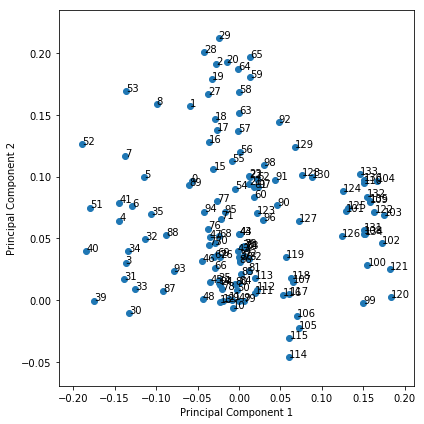

In [91]:
%matplotlib inline
fig = plt.figure(figsize = (6,6))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

#### Looking at the screeplot to assess the number of needed principal components

In [92]:
pd.options.display.float_format = '{:.2f}'.format
pca.explained_variance_ratio_

array([9.66449328e-02, 8.18963869e-02, 5.78483697e-02, 4.35718981e-02,
       3.53178108e-02, 3.24238332e-02, 3.09108813e-02, 2.87259862e-02,
       2.38622008e-02, 2.25692108e-02, 2.11956086e-02, 2.00066562e-02,
       1.93502378e-02, 1.85954568e-02, 1.71808562e-02, 1.65421804e-02,
       1.59387408e-02, 1.46586481e-02, 1.41255456e-02, 1.25678504e-02,
       1.22186482e-02, 1.17924817e-02, 1.16644432e-02, 1.06809560e-02,
       1.04622174e-02, 1.01728532e-02, 9.57757867e-03, 9.31236664e-03,
       9.07694533e-03, 8.87067798e-03, 8.43704846e-03, 8.25750205e-03,
       8.21381197e-03, 7.73022519e-03, 7.58372973e-03, 7.50825413e-03,
       7.17341272e-03, 7.05557421e-03, 6.76115015e-03, 6.72197754e-03,
       6.48995745e-03, 6.44161600e-03, 6.29529893e-03, 5.80921568e-03,
       5.75768986e-03, 5.61615718e-03, 5.38178410e-03, 5.07995011e-03,
       4.97837701e-03, 4.86035731e-03, 4.70950544e-03, 4.38734316e-03,
       4.36907276e-03, 4.21109534e-03, 4.14298419e-03, 3.95927946e-03,
      

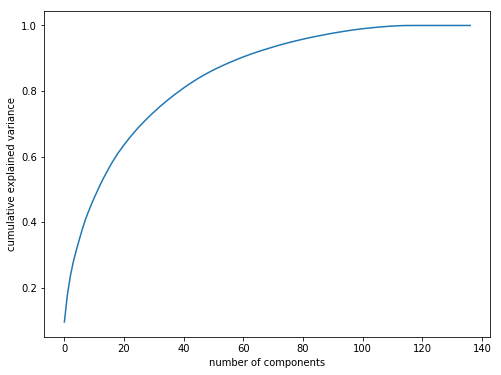

In [93]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### Let us choose the # of PCs such that 95% of cumulative variance is captured by the model

In [94]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca_again = PCA(0.95)

In [95]:
#Doing the PCA on the train data
pca_again.fit(X_train_upsampled)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [96]:
pca_again.n_components_

78

#### Thus we see that only 78 features out of a total of 137 are sufficient to capture 95% of cumulative variance for the model.

In [97]:
pca_again.components_

array([[-0.05703643, -0.05868738, -0.02718163, ...,  0.15201926,
         0.15764028,  0.15074307],
       [ 0.09608423,  0.15727037,  0.19131115, ...,  0.05334571,
         0.08037727,  0.09737502],
       [ 0.07176035,  0.12171544,  0.11214568, ...,  0.05925978,
         0.07467044,  0.07847449],
       ...,
       [ 0.00097437,  0.10670737,  0.05973649, ..., -0.19707315,
         0.09046676,  0.03070362],
       [-0.30291572, -0.16912351, -0.20681278, ...,  0.20687018,
         0.14476778,  0.04165165],
       [ 0.07043785, -0.03915088, -0.06551924, ..., -0.05409463,
         0.03453089, -0.01381119]])

In [98]:
colnames = list(pd.DataFrame(X_train_upsampled).columns)
pcs_df = pd.DataFrame({'PC1':pca_again.components_[0],'PC2':pca_again.components_[1], 'Feature':colnames})
pcs_df.head()

PC1  PC2  Feature
0 -0.06 0.10        0
1 -0.06 0.16        1
2 -0.03 0.19        2
3 -0.14 0.03        3
4 -0.14 0.06        4

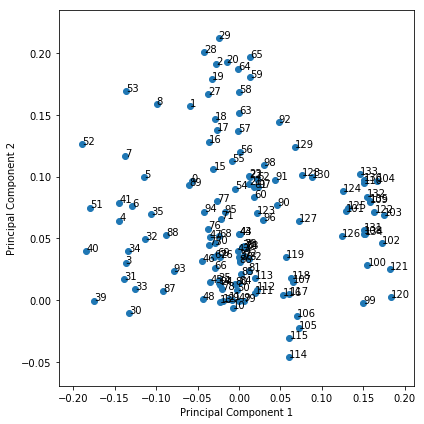

In [99]:
%matplotlib inline
fig = plt.figure(figsize = (6,6))
plt.scatter(pcs_df.PC1, pcs_df.PC2)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
for i, txt in enumerate(pcs_df.Feature):
    plt.annotate(txt, (pcs_df.PC1[i],pcs_df.PC2[i]))
plt.tight_layout()
plt.show()

In [100]:
X_train_upsampled_pca = pca_again.transform(X_train_upsampled)
X_test_upsampled_pca = pca_again.transform(X_test_upsampled)
X_train_upsampled_pca

array([[ 4.70046387, -0.83934552,  1.83803472, ...,  0.14260043,
         0.55056092, -0.04990571],
       [-0.64010897, -1.38594468, -2.53307812, ...,  0.36473089,
         0.57706116,  0.69892677],
       [ 1.56803163,  3.20859588, -0.64505033, ..., -0.03831873,
        -0.98701552, -0.55792272],
       ...,
       [ 0.99340755,  0.03709599, -1.1886838 , ...,  0.49247752,
         0.77689991, -0.01090636],
       [ 7.2815641 ,  0.17616417,  2.93696532, ...,  0.52220686,
         0.02588693,  0.24464375],
       [ 6.21297578,  1.01686812,  0.75375052, ...,  0.75960458,
         0.29045376, -0.23620941]])

#### Representing data points based on 1st and 2nd Principal Components

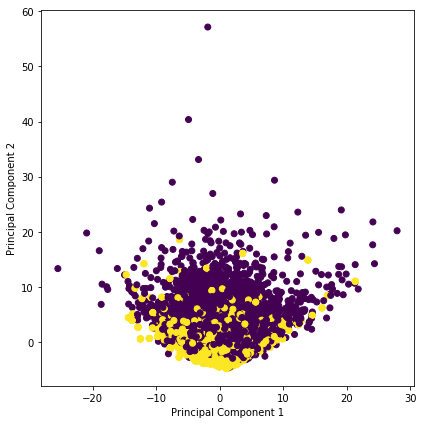

In [101]:
%matplotlib inline
fig = plt.figure(figsize = (6,6))
plt.scatter(X_train_upsampled_pca[:,0], X_train_upsampled_pca[:,1], c = y_train_upsampled)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

#### Representing data points based on 1st, 2nd and 3rd Principal Components

<IPython.core.display.Javascript object>


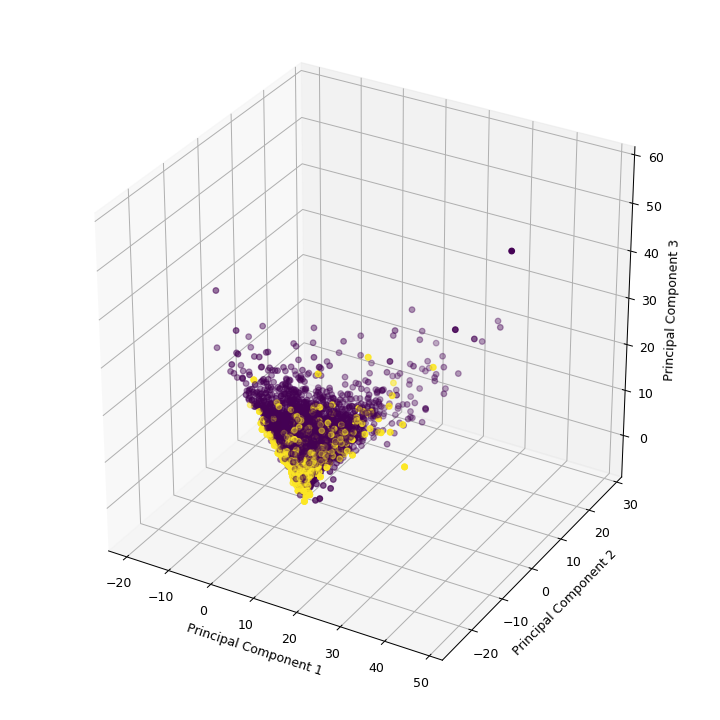

In [110]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,8))
ax = Axes3D(fig)
ax = plt.axes(projection='3d')
ax.scatter(X_train_upsampled_pca[:,2], X_train_upsampled_pca[:,0], X_train_upsampled_pca[:,1],zdir='z', s=20, marker = 'o', c=y_train_upsampled)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.tight_layout()
plt.show()

## Step 8: Model Building - Logistic Regression
Let's fist build a linear model with Logistic Regression and check the accuracies.

accuracy: 0.8295537010159652
              precision    recall  f1-score   support

           0       0.83      0.82      0.83     16542
           1       0.82      0.84      0.83     16530

   micro avg       0.83      0.83      0.83     33072
   macro avg       0.83      0.83      0.83     33072
weighted avg       0.83      0.83      0.83     33072



<IPython.core.display.Javascript object>


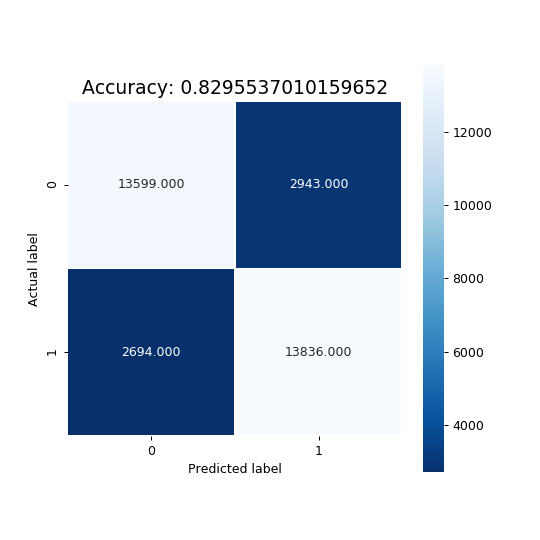

In [111]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
logisticRegr = LogisticRegression()
logisticRegr.fit(X=X_train_upsampled_pca, y=y_train_upsampled)

test_y_pred_balanced = logisticRegr.predict(X_test_upsampled_pca)
accuracy =  metrics.accuracy_score(y_test_upsampled, test_y_pred_balanced)
print("accuracy:", accuracy)
print(classification_report(y_test_upsampled, test_y_pred_balanced))

# Calculating confusion matrix
cmlr = metrics.confusion_matrix(y_true=y_test_upsampled, y_pred=test_y_pred_balanced)

# Plotting confusion matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

plt.figure(figsize=(6,6))
sns.heatmap(cmlr, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [112]:
TP = cmlr[1,1] # true positive 
TN = cmlr[0,0] # true negatives
FP = cmlr[0,1] # false positives
FN = cmlr[1,0] # false negatives

#### Showcasing the different metrics beyond accuracy on the test dataset

##### Sensitivity (TP / TP + FN)
# Let's see the sensitivity of our logistic regression model
print("Sensitivity:", TP / float(TP+FN))

##### Specificity(TN / TN + FP)
# Let us calculate specificity
print("Specificity:", TN / float(TN+FP))

##### False Postive Rate(FP / TN + FP)
# Calculate false postive rate - predicting churn when customer does not have churned
print("False Postive Rate:", FP/ float(TN+FP))

##### Positive Predictive Value(TP / TP + FP)
# Positive predictive value 
print("Positive Predictive Value:", TP / float(TP+FP))

##### Negative Predictive Value(TN / TN + FN)
# Negative predictive value
print("Negative Predictive Value:", TN / float(TN+ FN))

##### Precision(TP / TP + FP)
Precision = cmlr[1,1]/(cmlr[0,1]+cmlr[1,1])
print("Precision:", Precision)

##### Recall(TP / TP + FN)
Recall = cmlr[1,1]/(cmlr[1,0]+cmlr[1,1])
print("Recall:", Recall)

##### F1 = 2×(Precision*Recall)/(Precision+Recall)
F1 = 2*(Precision*Recall)/(Precision+Recall)
F1
print("F1 Score:", F1)

Sensitivity: 0.8370235934664246
Specificity: 0.8220892274211099
False Postive Rate: 0.1779107725788901
Positive Predictive Value: 0.8246021812980512
Negative Predictive Value: 0.8346529184312281
Precision: 0.8246021812980512
Recall: 0.8370235934664246
F1 Score: 0.8307664595154464


#### Plotting the ROC Curve for Test Dataset

In [113]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr, thresholds

In [114]:
fpr, tpr, thresholds = metrics.roc_curve( y_test_upsampled, test_y_pred_balanced, drop_intermediate = False )

<IPython.core.display.Javascript object>


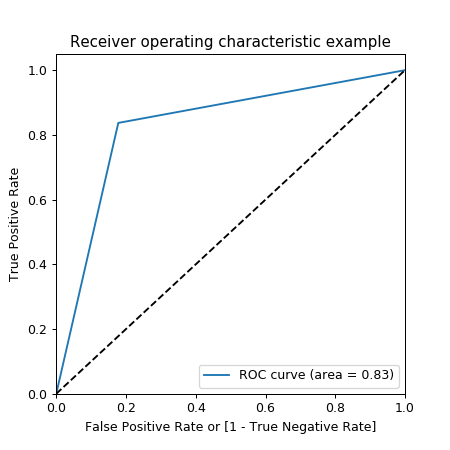

(array([0.        , 0.17791077, 1.        ]),
 array([0.        , 0.83702359, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [115]:
draw_roc(y_test_upsampled, test_y_pred_balanced)

### Calculating the Area Under the Curve(GINI)

In [116]:
def auc_val(fpr,tpr):
    AreaUnderCurve = 0.
    for i in range(len(fpr)-1):
        AreaUnderCurve += (fpr[i+1]-fpr[i]) * (tpr[i+1]+tpr[i])
    AreaUnderCurve *= 0.5
    return AreaUnderCurve

In [117]:
auc = auc_val(fpr,tpr)
auc

0.8295564104437673

#### So with Logistic regression, we get an accuracy of 0.83. Lets see if we can improve on the score with non-linear models like Random forest or SVM.

## Step 9: Model Building - Random Forest

Let's fist build  a non-linear model first with default hyperparameters and tune the hyper parameters



#### Default Hyperparameters
Let's first fit a random forest model with default hyperparameters.

In [119]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [120]:
# fit
rfc.fit(X_train_upsampled_pca,y_train_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [121]:
# Making predictions
predictions = rfc.predict(X_test_upsampled_pca)

In [122]:
# Let's check the report of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score

print(classification_report(y_test_upsampled,predictions))

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     16542
           1       0.96      0.99      0.97     16530

   micro avg       0.97      0.97      0.97     33072
   macro avg       0.97      0.97      0.97     33072
weighted avg       0.97      0.97      0.97     33072



In [123]:
# Printing confusion matrix
print(confusion_matrix(y_test_upsampled,predictions))

[[15816   726]
 [  159 16371]]


In [124]:
print(accuracy_score(y_test_upsampled,predictions))

0.9732402031930334


#### So with Random forest with default hyper parameters, we get an accuracy of 0.97. Lets see if we can improve by tuning the hyper parameters.

### Hyperparameter Tuning

### Tuning max_depth

Let's try to find the optimum values for ```max_depth``` and understand how the value of max_depth impacts the overall accuracy of the ensemble.


In [125]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(5, 50, 10)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train_upsampled_pca, y_train_upsampled)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(5, 50, 10)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

In [126]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0           0.96          0.08             0.02            0.01   
1           2.42          0.18             0.03            0.00   
2           2.65          0.09             0.03            0.00   
3           2.84          0.17             0.02            0.00   
4           2.62          0.06             0.03            0.01   

  param_max_depth             params  split0_test_score  split1_test_score  \
0               5   {'max_depth': 5}               0.82               0.82   
1              15  {'max_depth': 15}               0.95               0.95   
2              25  {'max_depth': 25}               0.96               0.96   
3              35  {'max_depth': 35}               0.96               0.96   
4              45  {'max_depth': 45}               0.96               0.96   

   split2_test_score  split3_test_score       ...         mean_test_score  \
0               0.82               0.82       ...                    0.82   
1               0.95               0.96       ...                    0.95   
2               0.96               0.97       ...                    0.96   
3               0.97               0.97       ...                    0.97   
4               0.97               0.97       ...                    0.96   

   std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0            0.00                5                0.83                0.83   
1            0.00                4                0.99                0.99   
2            0.00                3                1.00                1.00   
3            0.00                1                1.00                1.00   
4            0.00                2                1.00                1.00   

   split2_train_score  split3_train_score  split4_train_score  \
0                0.83                0.83                0.83   
1                0.99                0.99                0.98   
2                1.00                1.00                1.00   
3                1.00                1.00                1.00   
4                1.00                1.00                1.00   

   mean_train_score  std_train_score  
0              0.83             0.00  
1              0.99             0.00  
2              1.00             0.00  
3              1.00             0.00  
4              1.00             0.00  

[5 rows x 21 columns]

<IPython.core.display.Javascript object>


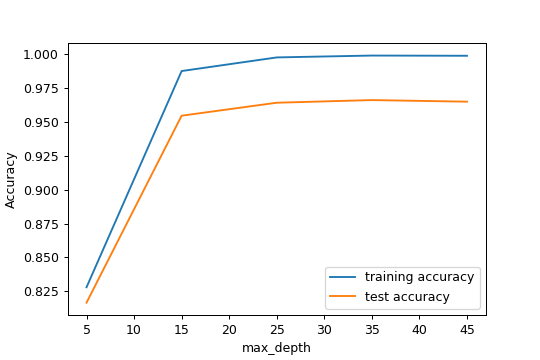

In [127]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


*Apparently, the training and test scores *both* seem to increase upto a certain point before becoming constant as we increase max_depth, and the model doesn't seem to overfit more with increasing max_depth.*

In [128]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',rf.best_score_,'using',rf.best_params_)

We can get accuracy of 0.9660740203193033 using {'max_depth': 35}


### Tuning max_features

Let's see how the model performance varies with ```max_features```, which is the maximum numbre of features considered for splitting at a node.

In [129]:
# GridSearchCV to find optimal max_features
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [2,4, 8, 14, 20]}

# instantiate the model
rf = RandomForestClassifier(max_depth=25)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train_upsampled_pca, y_train_upsampled)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_features': [2, 4, 8, 14, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [130]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0           0.61          0.02             0.02            0.00   
1           1.22          0.20             0.02            0.00   
2           1.97          0.09             0.02            0.00   
3           3.36          0.09             0.02            0.00   
4           4.74          0.05             0.02            0.00   

  param_max_features                params  split0_test_score  \
0                  2   {'max_features': 2}               0.97   
1                  4   {'max_features': 4}               0.96   
2                  8   {'max_features': 8}               0.96   
3                 14  {'max_features': 14}               0.96   
4                 20  {'max_features': 20}               0.96   

   split1_test_score  split2_test_score  split3_test_score       ...         \
0               0.96               0.97               0.97       ...          
1               0.96               0.97               0.97       ...          
2               0.96               0.96               0.97       ...          
3               0.96               0.96               0.96       ...          
4               0.96               0.96               0.96       ...          

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0             0.97            0.00                1                1.00   
1             0.97            0.00                2                1.00   
2             0.96            0.00                3                1.00   
3             0.96            0.00                4                1.00   
4             0.96            0.00                5                1.00   

   split1_train_score  split2_train_score  split3_train_score  \
0                1.00                1.00                1.00   
1                1.00                1.00                1.00   
2                1.00                1.00                1.00   
3                1.00                1.00                1.00   
4                1.00                1.00                1.00   

   split4_train_score  mean_train_score  std_train_score  
0                1.00              1.00             0.00  
1                1.00              1.00             0.00  
2                1.00              1.00             0.00  
3                1.00              1.00             0.00  
4                1.00              1.00             0.00  

[5 rows x 21 columns]

<IPython.core.display.Javascript object>


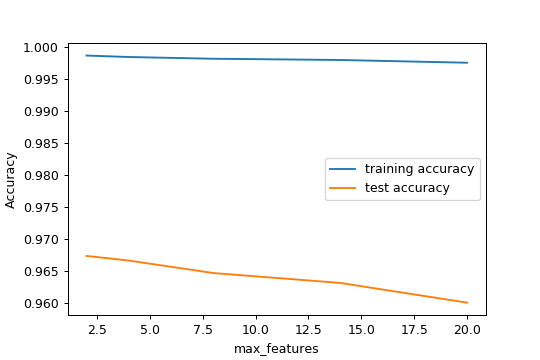

In [131]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


You can see that as we increase the value of max_features, train score almost remains constant at 1 but test scores gradually drops and thus this the ensemble tries to overfit as we increase the max_features.

Thus, controlling the max_features in the nodes of constituent trees will help reduce overfitting in the forest.

In [132]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',rf.best_score_,'using',rf.best_params_)

We can get accuracy of 0.967343976777939 using {'max_features': 2}


### Tuning min_samples_leaf

The hyperparameter **min_samples_leaf** is the minimum number of samples required to be at a leaf node:
- If int, then consider min_samples_leaf as the minimum number.
- If float, then min_samples_leaf is a percentage and ceil(min_samples_leaf * n_samples) are the minimum number of samples for each node.

Let's now check the optimum value for min samples leaf in our case.

In [133]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 100, 20)}

# instantiate the model
rf = RandomForestClassifier(max_depth=25)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train_upsampled_pca, y_train_upsampled)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_leaf': range(5, 100, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [134]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0           1.95          0.16             0.02            0.00   
1           1.52          0.05             0.02            0.00   
2           1.36          0.02             0.01            0.00   
3           1.30          0.03             0.01            0.00   
4           1.23          0.01             0.01            0.00   

  param_min_samples_leaf                    params  split0_test_score  \
0                      5   {'min_samples_leaf': 5}               0.94   
1                     25  {'min_samples_leaf': 25}               0.89   
2                     45  {'min_samples_leaf': 45}               0.87   
3                     65  {'min_samples_leaf': 65}               0.85   
4                     85  {'min_samples_leaf': 85}               0.84   

   split1_test_score  split2_test_score  split3_test_score       ...         \
0               0.94               0.94               0.94       ...          
1               0.89               0.88               0.89       ...          
2               0.87               0.86               0.87       ...          
3               0.85               0.85               0.85       ...          
4               0.84               0.85               0.84       ...          

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0             0.94            0.00                1                0.98   
1             0.89            0.00                2                0.91   
2             0.86            0.01                3                0.89   
3             0.85            0.00                4                0.86   
4             0.84            0.00                5                0.86   

   split1_train_score  split2_train_score  split3_train_score  \
0                0.98                0.98                0.98   
1                0.92                0.92                0.92   
2                0.88                0.88                0.89   
3                0.87                0.87                0.87   
4                0.86                0.86                0.85   

   split4_train_score  mean_train_score  std_train_score  
0                0.98              0.98             0.00  
1                0.91              0.92             0.00  
2                0.88              0.89             0.00  
3                0.87              0.87             0.00  
4                0.86              0.86             0.00  

[5 rows x 21 columns]

<IPython.core.display.Javascript object>


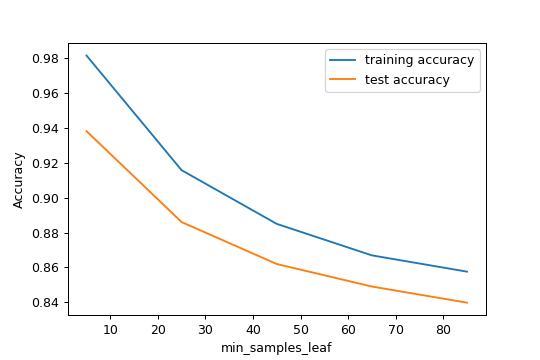

In [135]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

You can see that the model starts of overfit as you increase the value of min_samples_leaf. 

In [136]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',rf.best_score_,'using',rf.best_params_)

We can get accuracy of 0.938271044992743 using {'min_samples_leaf': 5}


### Tuning min_samples_split

Let's now look at the performance of the ensemble as we vary min_samples_split.

In [137]:
##### GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(10, 300, 50)}

# instantiate the model
rf = RandomForestClassifier(max_depth=25)


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
rf.fit(X_train_upsampled_pca, y_train_upsampled)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': range(10, 300, 50)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [138]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0           1.92          0.03             0.02            0.00   
1           1.82          0.08             0.02            0.00   
2           1.72          0.04             0.02            0.00   
3           1.61          0.02             0.01            0.00   
4           1.53          0.03             0.01            0.00   

  param_min_samples_split                      params  split0_test_score  \
0                      10   {'min_samples_split': 10}               0.95   
1                      60   {'min_samples_split': 60}               0.91   
2                     110  {'min_samples_split': 110}               0.88   
3                     160  {'min_samples_split': 160}               0.87   
4                     210  {'min_samples_split': 210}               0.86   

   split1_test_score  split2_test_score  split3_test_score       ...         \
0               0.95               0.96               0.95       ...          
1               0.90               0.92               0.92       ...          
2               0.88               0.88               0.88       ...          
3               0.86               0.86               0.86       ...          
4               0.85               0.86               0.86       ...          

   mean_test_score  std_test_score  rank_test_score  split0_train_score  \
0             0.95            0.00                1                0.99   
1             0.91            0.01                2                0.95   
2             0.88            0.00                3                0.91   
3             0.86            0.00                4                0.89   
4             0.86            0.01                5                0.87   

   split1_train_score  split2_train_score  split3_train_score  \
0                0.99                0.99                0.99   
1                0.95                0.95                0.95   
2                0.92                0.91                0.91   
3                0.89                0.89                0.89   
4                0.88                0.88                0.88   

   split4_train_score  mean_train_score  std_train_score  
0                0.99              0.99             0.00  
1                0.95              0.95             0.00  
2                0.91              0.91             0.00  
3                0.89              0.89             0.00  
4                0.88              0.88             0.00  

[5 rows x 21 columns]

<IPython.core.display.Javascript object>


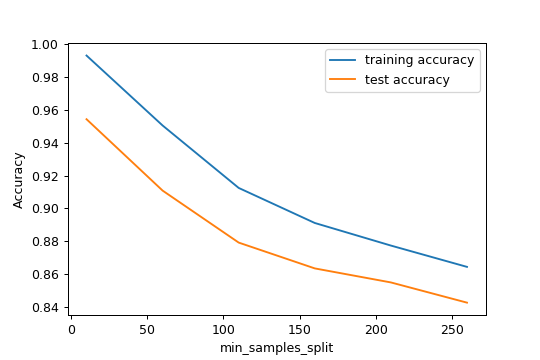

In [139]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

You can see that the model starts of overfit as you increase the value of min_samples_split. 

In [140]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',rf.best_score_,'using',rf.best_params_)

We can get accuracy of 0.9542815674891146 using {'min_samples_split': 10}


## Grid Search to Find Optimal Hyperparameters

We can now find the optimal hyperparameters using GridSearchCV.

In [141]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [15, 25],
    'min_samples_leaf': range(10, 100, 50),
    'min_samples_split': range(10, 100, 50),
    'n_estimators': [100,200, 300], 
    'max_features': [4, 8]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [142]:
# Fit the grid search to the data
grid_search.fit(X_train_upsampled_pca, y_train_upsampled)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 18.8min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [15, 25], 'min_samples_leaf': range(10, 100, 50), 'min_samples_split': range(10, 100, 50), 'n_estimators': [100, 200, 300], 'max_features': [4, 8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [143]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.9259343251088534 using {'max_depth': 25, 'max_features': 4, 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 100}


**Fitting the final model with the best parameters obtained from grid search.**

In [144]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=25,
                             min_samples_leaf=10, 
                             min_samples_split=10,
                             max_features=4,
                             n_estimators=100)

In [145]:
# fit
rfc.fit(X_train_upsampled_pca,y_train_upsampled)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [146]:
# predict
predictions = rfc.predict(X_test_upsampled_pca)

accuracy: 0.9453918722786647
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     16542
           1       0.93      0.96      0.95     16530

   micro avg       0.95      0.95      0.95     33072
   macro avg       0.95      0.95      0.95     33072
weighted avg       0.95      0.95      0.95     33072



<IPython.core.display.Javascript object>


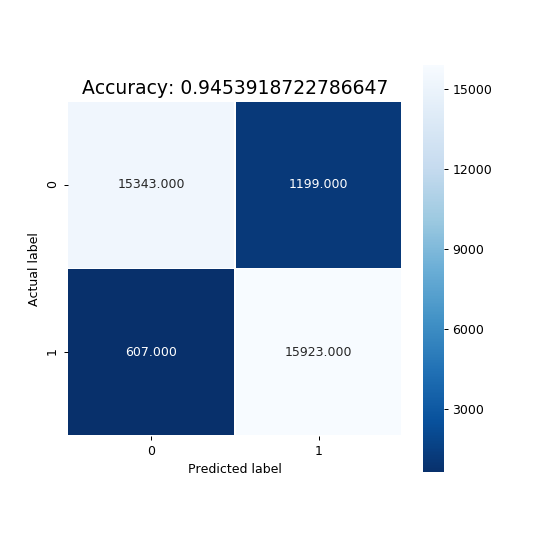

In [147]:
accuracy =  metrics.accuracy_score(y_test_upsampled, predictions)
print("accuracy:", accuracy)
print(classification_report(y_test_upsampled, predictions))

# Calculating confusion matrix
cmrf = metrics.confusion_matrix(y_true=y_test_upsampled, y_pred=predictions)

# Plotting confusion matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

plt.figure(figsize=(6,6))
sns.heatmap(cmrf, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [148]:
TP = cmrf[1,1] # true positive 
TN = cmrf[0,0] # true negatives
FP = cmrf[0,1] # false positives
FN = cmrf[1,0] # false negatives

#### Showcasing the different metrics beyond accuracy on the test dataset

##### Sensitivity (TP / TP + FN)
# Let's see the sensitivity of our logistic regression model
print("Sensitivity:", TP / float(TP+FN))

##### Specificity(TN / TN + FP)
# Let us calculate specificity
print("Specificity:", TN / float(TN+FP))

##### False Postive Rate(FP / TN + FP)
# Calculate false postive rate - predicting churn when customer does not have churned
print("False Postive Rate:", FP/ float(TN+FP))

##### Positive Predictive Value(TP / TP + FP)
# Positive predictive value 
print("Positive Predictive Value:", TP / float(TP+FP))

##### Negative Predictive Value(TN / TN + FN)
# Negative predictive value
print("Negative Predictive Value:", TN / float(TN+ FN))

##### Precision(TP / TP + FP)
Precision = cmrf[1,1]/(cmrf[0,1]+cmrf[1,1])
print("Precision:", Precision)

##### Recall(TP / TP + FN)
Recall = cmrf[1,1]/(cmrf[1,0]+cmrf[1,1])
print("Recall:", Recall)

##### F1 = 2×(Precision*Recall)/(Precision+Recall)
F1 = 2*(Precision*Recall)/(Precision+Recall)
F1
print("F1 Score:", F1)

Sensitivity: 0.9632788868723533
Specificity: 0.9275178333937855
False Postive Rate: 0.07248216660621448
Positive Predictive Value: 0.9299731339796753
Negative Predictive Value: 0.9619435736677115
Precision: 0.9299731339796753
Recall: 0.9632788868723533
F1 Score: 0.9463330559847856


#### Plotting the ROC Curve for Test Dataset

In [149]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr, thresholds

In [150]:
fpr, tpr, thresholds = metrics.roc_curve( y_test_upsampled, predictions, drop_intermediate = False )

<IPython.core.display.Javascript object>


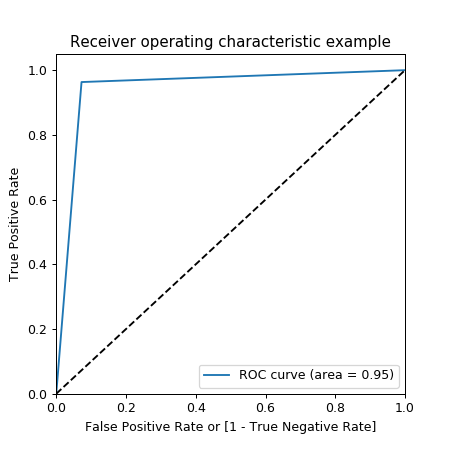

(array([0.        , 0.07248217, 1.        ]),
 array([0.        , 0.96327889, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [151]:
draw_roc(y_test_upsampled, predictions)

### Calculating the Area Under the Curve(GINI)

In [152]:
def auc_val(fpr,tpr):
    AreaUnderCurve = 0.
    for i in range(len(fpr)-1):
        AreaUnderCurve += (fpr[i+1]-fpr[i]) * (tpr[i+1]+tpr[i])
    AreaUnderCurve *= 0.5
    return AreaUnderCurve

In [153]:
auc = auc_val(fpr,tpr)
auc

0.9453983601330692

#### With chosen hyper parameters, Random forest model gives us an accuracy of 0.95. Lets see if we can do any better with SVM models.

## Step 10: Model Building - SVM

Let's fist build two basic models - linear and non-linear with default hyperparameters, and compare the accuracies.

In [154]:
# linear model

model_linear = SVC(kernel='linear')
model_linear.fit(X_train_upsampled_pca, y_train_upsampled)

# predict
y_test_pred = model_linear.predict(X_test_upsampled_pca)

In [155]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test_upsampled, y_pred=y_test_pred), "\n")
print(classification_report(y_test_upsampled, predictions))

accuracy: 0.8335752298016449 

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     16542
           1       0.93      0.96      0.95     16530

   micro avg       0.95      0.95      0.95     33072
   macro avg       0.95      0.95      0.95     33072
weighted avg       0.95      0.95      0.95     33072



#### The linear model gives approx. 84% accuracy like Logistic Regression. Let's look at a sufficiently non-linear model with randomly chosen hyperparameters.

In [156]:
# non-linear model
# using rbf kernel, C=1, default value of gamma

# model
non_linear_model = SVC(kernel='rbf')

# fit
non_linear_model.fit(X_train_upsampled_pca, y_train_upsampled)

# predict
y_test_pred = non_linear_model.predict(X_test_upsampled_pca)

In [157]:
# confusion matrix and accuracy

# accuracy
print("accuracy:", metrics.accuracy_score(y_true=y_test_upsampled, y_pred=y_test_pred), "\n")
print(classification_report(y_test_upsampled, predictions))

accuracy: 0.910951862602806 

              precision    recall  f1-score   support

           0       0.96      0.93      0.94     16542
           1       0.93      0.96      0.95     16530

   micro avg       0.95      0.95      0.95     33072
   macro avg       0.95      0.95      0.95     33072
weighted avg       0.95      0.95      0.95     33072



#### The non-linear model gives approx. 91% accuracy. Thus, going forward, let's choose hyperparameters corresponding to non-linear models.

### Grid Search - Hyperparameter Tuning

Let's now tune the model to find the optimal values of C and gamma corresponding to an RBF kernel. We'll use 4-fold cross validation.

In [158]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 101)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs = -1)      

# fit the mode`l
model_cv.fit(X_train_upsampled_pca, y_train_upsampled)                  


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 23.2min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 39.7min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=101, shuffle=True),
       error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid=[{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [159]:
# cv results
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0           63.67          0.71             6.64            0.04       1   
1           59.79          0.49             7.02            0.15       1   
2           72.28          1.05             8.79            0.11       1   
3          154.39         21.51             8.93            1.23      10   
4           67.74         10.80             6.64            0.12      10   
5           59.68          0.65             7.33            0.18      10   
6          182.38          4.43             6.05            0.14     100   
7           76.76          1.50             6.06            0.12     100   
8           61.43          1.91             6.95            0.33     100   
9          211.65         24.01             6.49            0.95    1000   
10         256.54         39.25             7.46            1.69    1000   
11         134.20          6.21             8.95            1.02    1000   

   param_gamma                        params  split0_test_score  \
0         0.01       {'C': 1, 'gamma': 0.01}               0.90   
1         0.00      {'C': 1, 'gamma': 0.001}               0.85   
2         0.00     {'C': 1, 'gamma': 0.0001}               0.82   
3         0.01      {'C': 10, 'gamma': 0.01}               0.93   
4         0.00     {'C': 10, 'gamma': 0.001}               0.87   
5         0.00    {'C': 10, 'gamma': 0.0001}               0.83   
6         0.01     {'C': 100, 'gamma': 0.01}               0.94   
7         0.00    {'C': 100, 'gamma': 0.001}               0.89   
8         0.00   {'C': 100, 'gamma': 0.0001}               0.85   
9         0.01    {'C': 1000, 'gamma': 0.01}               0.94   
10        0.00   {'C': 1000, 'gamma': 0.001}               0.91   
11        0.00  {'C': 1000, 'gamma': 0.0001}               0.87   

    split1_test_score  split2_test_score       ...         mean_test_score  \
0                0.91               0.90       ...                    0.90   
1                0.85               0.85       ...                    0.84   
2                0.82               0.83       ...                    0.82   
3                0.93               0.93       ...                    0.93   
4                0.87               0.87       ...                    0.87   
5                0.84               0.85       ...                    0.84   
6                0.94               0.95       ...                    0.95   
7                0.90               0.89       ...                    0.90   
8                0.85               0.85       ...                    0.85   
9                0.94               0.94       ...                    0.94   
10               0.91               0.92       ...                    0.92   
11               0.86               0.87       ...                    0.87   

    std_test_score  rank_test_score  split0_train_score  split1_train_score  \
0             0.00                5                0.91                0.91   
1             0.00               10                0.85                0.85   
2             0.01               12                0.83                0.83   
3             0.00                3                0.96                0.96   
4             0.00                7                0.88                0.88   
5             0.01               11                0.84                0.84   
6             0.00                1                0.99                0.99   
7             0.00                6                0.91                0.91   
8             0.00                9                0.85                0.85   
9             0.01                2                1.00                1.00   
10            0.00                4                0.95                0.95   
11            0.00                8                0.88                0.87   

    split2_train_score  split3_train_score  split4_train_score  \
0                 0.92            

<IPython.core.display.Javascript object>


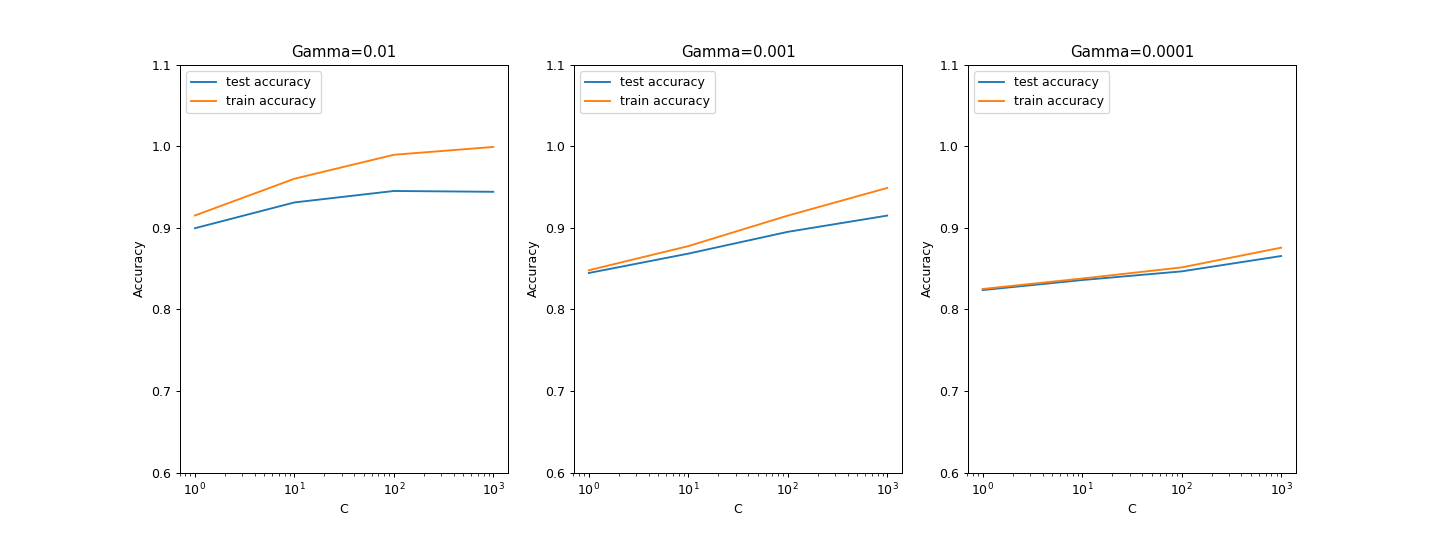

In [160]:
# converting C to numeric type for plotting on x-axis
cv_results['param_C'] = cv_results['param_C'].astype('int')

# # plotting
plt.figure(figsize=(16,6))

# subplot 1/3
plt.subplot(131)
gamma_01 = cv_results[cv_results['param_gamma']==0.01]

plt.plot(gamma_01["param_C"], gamma_01["mean_test_score"])
plt.plot(gamma_01["param_C"], gamma_01["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.01")
plt.ylim([0.60, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

# subplot 2/3
plt.subplot(132)
gamma_001 = cv_results[cv_results['param_gamma']==0.001]

plt.plot(gamma_001["param_C"], gamma_001["mean_test_score"])
plt.plot(gamma_001["param_C"], gamma_001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.001")
plt.ylim([0.60, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')


# subplot 3/3
plt.subplot(133)
gamma_0001 = cv_results[cv_results['param_gamma']==0.0001]

plt.plot(gamma_0001["param_C"], gamma_0001["mean_test_score"])
plt.plot(gamma_0001["param_C"], gamma_0001["mean_train_score"])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title("Gamma=0.0001")
plt.ylim([0.60, 1.1])
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

The plots above show some useful insights:
- Non-linear models (with high gamma) perform *much better* than completely/moderately linear ones(very low to low gamma).
- The model doesn't tend to overfit at high values of gamma. 
- At any given value of gamma, a C with a value of 100 leads to better performance. 

This suggests that the problem and the data is **highly non-linear in nature**, and a complex model will outperform simple, linear models and not overfit at the same time in this case.

Let's now choose the best hyperparameters. 

In [161]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9452558055152395 corresponding to hyperparameters {'C': 100, 'gamma': 0.01}


accuracy: 0.9503809869375908
classification_report:               precision    recall  f1-score   support

           0       0.99      0.91      0.95     16542
           1       0.92      0.99      0.95     16530

   micro avg       0.95      0.95      0.95     33072
   macro avg       0.95      0.95      0.95     33072
weighted avg       0.95      0.95      0.95     33072



<IPython.core.display.Javascript object>


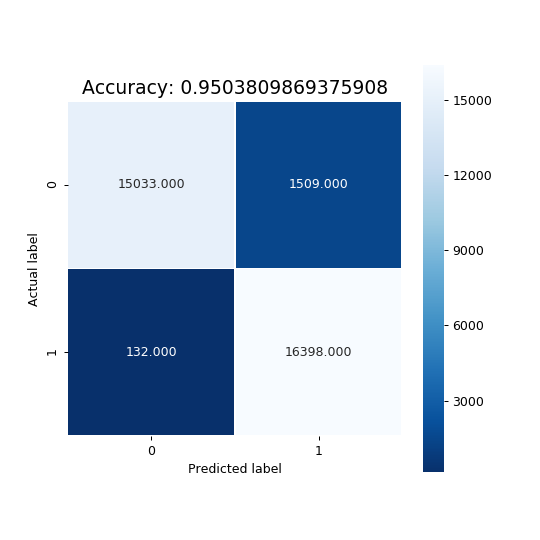

In [162]:
# model with optimal hyperparameters

# model
final_model = SVC(C=100, gamma=0.01, kernel="rbf")

final_model.fit(X_train_upsampled_pca, y_train_upsampled)
y_test_pred = final_model.predict(X_test_upsampled_pca)

# printing accuracy
accuracy =  metrics.accuracy_score(y_test_upsampled, y_test_pred)
print("accuracy:", accuracy)

# Printing classification report
print("classification_report:", classification_report(y_test_upsampled, y_test_pred))

# Calculating confusion matrix
cmsvm = metrics.confusion_matrix(y_true=y_test_upsampled, y_pred=y_test_pred)

# Plotting confusion matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

plt.figure(figsize=(6,6))
sns.heatmap(cmsvm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy: {0}'.format(accuracy)
plt.title(all_sample_title, size = 15);

In [163]:
TP = cmsvm[1,1] # true positive 
TN = cmsvm[0,0] # true negatives
FP = cmsvm[0,1] # false positives
FN = cmsvm[1,0] # false negatives

#### Showcasing the different metrics beyond accuracy on the test dataset

##### Sensitivity (TP / TP + FN)
# Let's see the sensitivity of our logistic regression model
print("Sensitivity:", TP / float(TP+FN))

##### Specificity(TN / TN + FP)
# Let us calculate specificity
print("Specificity:", TN / float(TN+FP))

##### False Postive Rate(FP / TN + FP)
# Calculate false postive rate - predicting churn when customer does not have churned
print("False Postive Rate:", FP/ float(TN+FP))

##### Positive Predictive Value(TP / TP + FP)
# Positive predictive value 
print("Positive Predictive Value:", TP / float(TP+FP))

##### Negative Predictive Value(TN / TN + FN)
# Negative predictive value
print("Negative Predictive Value:", TN / float(TN+ FN))

##### Precision(TP / TP + FP)
Precision = cmsvm[1,1]/(cmsvm[0,1]+cmsvm[1,1])
print("Precision:", Precision)

##### Recall(TP / TP + FN)
Recall = cmsvm[1,1]/(cmsvm[1,0]+cmsvm[1,1])
print("Recall:", Recall)

##### F1 = 2×(Precision*Recall)/(Precision+Recall)
F1 = 2*(Precision*Recall)/(Precision+Recall)
F1
print("F1 Score:", F1)

Sensitivity: 0.9920145190562614
Specificity: 0.9087776568734132
False Postive Rate: 0.09122234312658686
Positive Predictive Value: 0.9157312782710672
Negative Predictive Value: 0.991295746785361
Precision: 0.9157312782710672
Recall: 0.9920145190562614
F1 Score: 0.9523477654847984


#### Plotting the ROC Curve for Test Dataset

In [164]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return fpr,tpr, thresholds

In [165]:
fpr, tpr, thresholds = metrics.roc_curve( y_test_upsampled, y_test_pred, drop_intermediate = False )

<IPython.core.display.Javascript object>


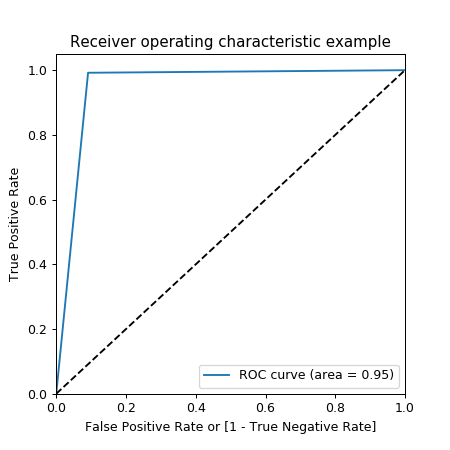

(array([0.        , 0.09122234, 1.        ]),
 array([0.        , 0.99201452, 1.        ]),
 array([2, 1, 0], dtype=int64))

In [166]:
draw_roc(y_test_upsampled, y_test_pred)

### Calculating the Area Under the Curve(GINI)

In [167]:
def auc_val(fpr,tpr):
    AreaUnderCurve = 0.
    for i in range(len(fpr)-1):
        AreaUnderCurve += (fpr[i+1]-fpr[i]) * (tpr[i+1]+tpr[i])
    AreaUnderCurve *= 0.5
    return AreaUnderCurve

In [168]:
auc = auc_val(fpr,tpr)
auc

0.9503960879648373

#### With a non linear SVM model (chosen hyper parameters), we get a test accuracy of 0.95

## Step 11: Model Selection

Criteria for model selection: *<font color = blue>It is is more important to identify churners than the non-churners accurately.</font>*

#### We started out with a simple linear model (Logistic Regression) and then eventually moved to more complex models.
#### Below is a short summary of all the models built to predict churned customers:

|Model|Accuracy|<font color = blue>Sensitivity</font>|Specificity|False Postive Rate|Positive Predictive Value|Negative Predictive value|Precision|Recall|F1 Score|AUC|
|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|-----|
|`Logistic Regression`|0.83|<font color = blue>0.84</font>|0.82|0.18|0.82|0.83|0.82|0.84|0.83|0.83|
|`Random Forest`|0.95|<font color = blue>0.96</font>|0.93|0.07|0.93|0.96|0.93|0.96|0.95|0.95|
|`SVM`|0.95|<font color = red>0.99</font>|0.91|0.09|0.92|0.99|0.92|0.99|0.95|0.95|

`Sensitivity` in our context can be defined as a measure of total no of actual Churns correctly predicted out of the total no of actual Churns. It is also referred to as `True Positive Rate` or simple as `Recall`.

The business goal here is to identify churners more accurately than to identify the non-churners. Hence the evaluation metric that satisfies the business goal is Sensitivity.

From the above table, we see that the Support Vector Model has the best value for Sensitivity(99%).ie. the model can accurately predict 99% of the churned customers.

`Hence our chosen model is the SVM model.`

## Step 12: Determining Feature Importance

#### The earlier models were build after applying PCA. Hence determining feature importance from these models will be an issue.

*So we will be building a Decision Tree model on based on original feature set and then determine the features that are most important in deciding if a customer will churn or not.*

In [169]:
#train, test = train_test_split(telecom_upsampled, test_size = 0.6)
print(train.shape)
print(test.shape)

(22048, 139)
(33072, 139)


In [170]:
# Putting feature variables to X
# Putting response variable to y
X_train_dt = train.drop(['mobile_number','churn'], axis=1)
X_test_dt = test.drop(['mobile_number','churn'], axis=1)
y_train_dt = train['churn']
y_test_dt = test['churn']

print(X_train_dt.shape)
print(y_train_dt.shape)
print(X_test_dt.shape)
print(y_test_dt.shape)

(22048, 137)
(22048,)
(33072, 137)
(33072,)


In [128]:
from sklearn.preprocessing import StandardScaler

In [171]:
# Using sklearn Standard Scaler to normalize the feature variables
scaler = StandardScaler()

X_train_dt = scaler.fit_transform(X_train_dt)
X_test_dt = scaler.transform(X_test_dt)

pd.DataFrame(X_train_dt).head()

0     1     2     3     4     5     6     7     8     9    ...    127  \
0 -0.66 -0.79 -0.05 -0.57 -0.55 -0.44 -0.68 -0.68 -0.58 -0.20  ...   0.31   
1 -0.04 -0.60 -0.74 -0.57 -0.54 -0.44  0.39 -0.27 -0.58 -0.20  ...  -0.29   
2  0.81 -0.97  2.36 -0.41 -0.55 -0.37 -0.22 -0.69 -0.28 -0.11  ...   0.23   
3 -0.85 -0.18 -0.74 -0.58 -0.55 -0.44 -0.69 -0.62 -0.58 -0.20  ...  -0.67   
4  0.09  0.13 -0.14 -0.47 -0.43 -0.36  1.38  1.02  0.16 -0.20  ...  -0.19   

    128   129   130   131   132   133   134   135   136  
0 -0.47  3.33 -0.13 -0.23 -0.16  1.67 -0.50 -0.47  1.33  
1 -0.50 -0.47 -0.48 -0.25 -0.36 -0.31 -0.50 -0.47 -0.40  
2 -0.69  1.51 -0.31 -0.39 -0.37 -0.31 -0.50 -0.47 -0.40  
3 -0.19 -0.47 -0.49 -0.39  0.45 -0.31 -0.50  1.01 -0.40  
4 -0.24 -0.29 -0.26 -0.39 -0.37 -0.31 -0.50 -0.47 -0.40  

[5 rows x 137 columns]

In [172]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(criterion = "gini", max_depth=5)
dt_default.fit(X_train_dt, y_train_dt)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [173]:
# Let's check the evaluation metrics of our default model

# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
y_pred_default = dt_default.predict(X_test_dt)

# Printing classification report
print(classification_report(y_test_dt, y_pred_default))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     16542
           1       0.85      0.86      0.85     16530

   micro avg       0.85      0.85      0.85     33072
   macro avg       0.85      0.85      0.85     33072
weighted avg       0.85      0.85      0.85     33072



In [174]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test_dt,y_pred_default))
print(accuracy_score(y_test_dt,y_pred_default))

[[13947  2595]
 [ 2277 14253]]
0.8526850507982583


### Plotting the Decision Tree

In [175]:
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

# Putting features into a variable
features = list(train.drop(['mobile_number','churn'], axis=1).columns[:])
features

['arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'loc_ic_t

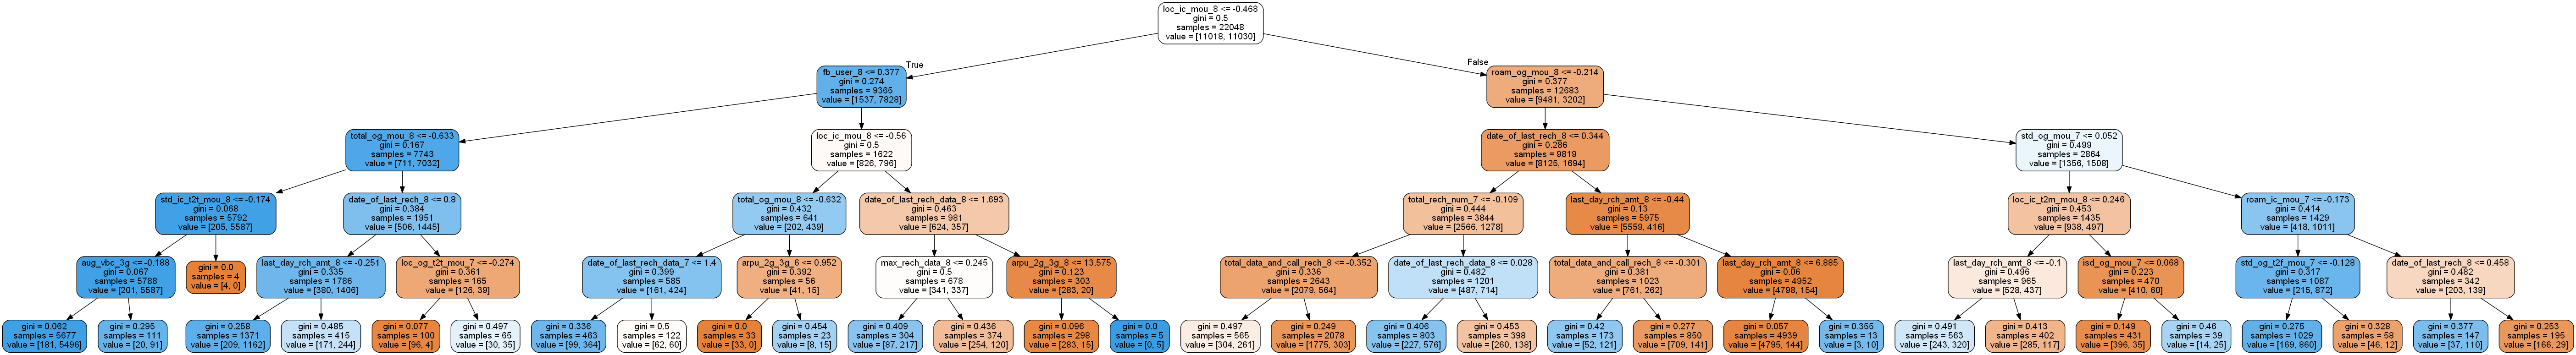

In [176]:
# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(dt_default, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Displaying the feautures with their gini scores

In [316]:
# Capturing the feature importances from the tree model properties into a dataframe and seleting the top 10 features
feature_importance = dt_default.feature_importances_
fi = pd.concat([pd.DataFrame(features), pd.DataFrame(feature_importance)], axis = 1)
fi.columns = ['Features','Importance']
fi_sorted = fi.loc[fi['Importance']>0].sort_values(by=['Importance'],ascending=False)
fi_sorted_top10 = fi_sorted.head(10)
fi_sorted_top10

Features  Importance
65                 loc_ic_mou_8       0.561
14                roam_og_mou_8       0.083
95          date_of_last_rech_8       0.071
122                   fb_user_8       0.070
88             total_rech_num_7       0.036
40                 std_og_mou_7       0.028
98           last_day_rch_amt_8       0.027
129  total_data_and_call_rech_8       0.026
53               total_og_mou_8       0.025
101    date_of_last_rech_data_8       0.023

### Visually Identifying the Top Indicators of Churn.

In [2]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(15,8), dpi=80, facecolor='w', edgecolor='k', frameon='True')
pal = ["#ff9999", "#99d8c9", "#2ca25f", "#8856a7","#66b3ff","#fdbb84","#e34a33","#bdbdbd","#f7fcb9","#99ff99","#f7fcb9","#fec44f","#d95f0e","#dd1c77","#99ff99"]
names = list(fi_sorted_top10.Features)
explode = (0.1, 0.1, 0.1, 0.1,0.1,0.1,0.1,0.1,0.1,0.1)

# subplot 1
plt.subplot(1, 2, 1)
patches, texts, autotexts = plt.pie(fi_sorted_top10['Importance'], labels=names, startangle=235, colors = pal, autopct='%.1f%%',shadow=True,explode=explode)
plt.title("Percentage Importance of Top 10 Indicators of churn",fontsize=12)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
for autotext in autotexts:
    autotext.set_color('blue')

# subplot 2
plt.subplot(1, 2, 2)
sns.barplot(y='Features', x='Importance', palette='coolwarm', data=fi_sorted, estimator=np.sum)
plt.yticks(size = 10)
plt.title("Importance of Features in Telecom Churn",fontsize=12)
plt.xlabel('Importance', fontsize = 12, color='r')
plt.ylabel('Features', fontsize = 12, color='r')

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()


NameError: name 'plt' is not defined

## Step 13: Conclusion and Recommendation

#### <font color = blue>The top 10 Indicators for Customer Churn based on GINI Scores are as below:</font>

|Features|	Importance|
|------|---------|
|loc_ic_mou_8|	0.561|
|	roam_og_mou_8|	0.083|
|	date_of_last_rech_8|	0.071|
|	fb_user_8|	0.070|
|	total_rech_num_7|	0.036|
|	std_og_mou_7|	0.028|
|	last_day_rch_amt_8|	0.027|
|	total_data_and_call_rech_8|	0.026|
|	total_og_mou_8|	0.025|
|	date_of_last_rech_data_8|	0.023|

#### <font color = blue>Observations & Recommendations:</font>

 - Most of the Indicators are either features for the action phase (`August`) or 2nd half of the good phase (`July`).
 - `Local Incoming minutes of usage` in action phase has more importance than that of all the other features added together. This tell us that customers not receiving local incoming calls are most likely to churn soon. 
 - Costly `Roaming` charges(both incoming and outgoing) is an important criteria for churn. Attractive roaming packs may cause a customer to think twice before leaving the service provider.
 - Most telecom companies offer special `Facebook packs` as perks. I would recommend the telecom company to maybe have a special internet pack for Social networking sites targeted towards high-value customers.
 - `STD and ISD` are another two driving factors. Most of the competitors have attractive offers for STD and ISD calls. The telecom comany also need to match these perks amd start offering these services as bundles.